# $\Delta$ARG LEU$^{++}$&harr; $\Delta$LEU ARG$^{++}$ CoNoS Model 
Author: Daniel Strohmeier

### Assumptions


* Continuity
* Population average considered
* Ideally mixed reactor
* No oxygen or secondary substrate limitations (except auxotrophic amino acids)
* Uptake rates obey a Monod-type kinetic
* Secretion rates are lumped rates over the amino acid synthesis reactions and the transport to the bulk phase
* The substrate specific biomass yield $Y_{SX}^{dA/dL}$ is the same as of the lysine-producer strain *C. glutamicum ATCC 17965 - Kjeldesen 2008*
* Constant and known specific volume of bacteria
* No maintenance metabolism considered


### Used Packages

* pyFOOMB - *Hemmerich 2021*
* Numpy
* Pandas
* joblib
* os.path

### Import of Required Libraries

In [1]:
#Imports
from pyfoomb import *
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import joblib

np.random.seed(123)

Could not find GLIMDA.


# 1. Batch Model

### Structure
Model of CoNoS in a batch reactor. 
The model distinguishes between extracellular quantities (Suffix: $ex$) and intracellular quantities (Suffix: $in$).
The structure of the model includes:


* 3 **Storages / Devices**: 
 * $\Delta ArgLeu^{++}$: Population of C.Glutamicum auxotrophic for Arginie with enhanced Leucine pathway. (Suffix: $dA$)
 * $\Delta LeuArg^{+}$: Population of C.Glutamicum auxotrophic for Leucine with enhanced Arginine pathway- (Suffix: $dL$)
 * $LiquidPhase$: Quasi-homogeneous, ideally-mixed bulk phase of the reactor. (only $ex$ suffix used)
 
 
* 1 **Signal Transformer**: 
 * $ObservationFunctions$: Transforms backscatter signal into biomass concentration and vice-versa. ($BS$)


* 6 explicitly modeled **Rates**:
 * *UptA*: $LiquidPhase\xrightarrow{\text{v_upt_Arg_dA}}\Delta ArgLeu^{++}$
 * *UptL*: $LiquidPhase\xrightarrow{\text{v_upt_Leu_dL}}\Delta LeuArg^{+}$
 * *SecA*: $\Delta ArgLeu^{++}\xrightarrow{\text{v_syn_Leu_dA}}LiquidPhase$
 * *SecL*: $\Delta LeuArg^{+}\xrightarrow{\text{v_syn_Arg_dL}}LiquidPhase$
 * *GlcA*: $LiquidPhase\xrightarrow{\text{v_upt_S_dA}}\Delta ArgLeu^{++}$
 * *GlcL*: $LiquidPhase\xrightarrow{\text{v_upt_S_dL}}\Delta LeuArg^{+}$

![model structure - decomposition of BPM](Model_Structure2.png "Model Structure")



### State Variables

|Name         |Unit                  |Lower bound|Upper bound|Description                                        |
|:------------|:---------------------|:----------|:----------|:--------------------------------------------------|
|Arg_dA_in    |mmol Arg/l_cell       |0          |           |Arginine Concentration inside dArgLeu++ cells      |
|Arg_ex       |mmol Arg/l_reactor    |0          |           |Arginine Concentration in bulk phase               |
|Leu_dL_in    |mmol Leu/l_cell       |0          |           |Leucine Concentration inside dLeuArg+ cells        |
|Leu_ex       |mmol Leu/l_reactor    |0          |           |Leucine Concentration in bulk phase                |
|S_ex         |mmol Glc/l_reactor    |0          |S0         |Glucose Concentration in bulk phase                |
|S_dA_in      |mmol Glc/l_cell       |0          |           |Glucose Concentration inside dArgLeu++ cells       |
|S_dL_in      |mmol Glc/l_cell       |0          |           |Glucose Concentration inside dLeuArg+ cells        |
|X            |g Biomass/l_reactor   |X_dA0+X_dL0|           |Total biomass concentration                        |
|X_dA         |g Biomass/l_reactor   |X_dA0      |           |Biomass concentration of dArgLeu++ cells           |
|X_dL         |g Biomass/l_reactor   |X_dL0      |           |Biomass concentration of dLeuArg+ cells            |


In [2]:
initial_values              = {
    'S_ex0'                 : 80.0,                          #[mM]
    'S_dA_in0'              : 0.0,                           #[mM] 
    'S_dL_in0'              : 0.0,                           #[mM]
    'Arg_ex0'               : 0.0,                           #[mM]
    'Arg_dA_in0'            : 0.0,                           #[mM]
    'Leu_ex0'               : 0.0,                           #[mM]
    'Leu_dL_in0'            : 0.0,                           #[mM]
    'X0'                    : 0.5,                           #[g/l]
    'X_dA0'                 : 0.25,                          #[g/l]
    'X_dL0'                 : 0.25,                          #[g/l]  
}

### Model Parameters

Parameter bounds with source *MC* were obtained by a Monte Carlo sampling of the respective single cultivation model where the 16\% quantile serves as lower bound and the 84\% quantile as upper bound:


**MC1**: dArgLeu++\_Single\_Cultivation.ipynb

**MC2**: dLeuArg+\_Single\_Cultivation.ipynb

|Name             |Unit         |Lower|Mean|Upper|Source         |Description                      |
|:----------------|:------------|:----|:---|:----|:--------------|:--------------------------------|
|$dArgLeu^{++}$   |||||
|mu_max_dA        |1/h          |0.465068|0.476339|0.487649    |*MC1* |Maximum growth rate of dArgLeu++              |
|K_mu_S_dA      |mmol Glc/l_cell  |0.002548|0.002913|0.003114  |*MC1* |Affinity constant of glucose related to growth in dArgLeu++ |
|K_mu_Arg_dA      |mmol Arg/l_cell  |0.002423|0.002692|0.002961|*MC1*|Affinity constant of arginine related to growth in dArgLeu++|
|v_upt_S_max_dA   |mmol Glc/l_cell/h|2294.657064|2305.855702|2330.990886|*MC*|Maximum glucose uptake rate of dArgLeu++ |
|K_upt_S_dA       |mmol Glc /l_reactor|0.003157|0.003482|0.003859|*MC1*|Affinity constant of glucose uptake in dArgLeu++ |
|Y_S_X_dA         |mmol Glc/g_X |        |10.4099|   |Kjeldsen 2008|Yield coefficient of glucose for biomass composition minus the contribution of arginine (uptake) in dArgLeu++ |
|v_upt_Arg_max_dA |mmol Arg/l_cell/h|45.485241|48.283245|52.699782|*MC1*|Maximum arginine uptake rate of dArgLeu++|
|K_upt_Arg_dA     |mmol Arg/l_reactor|0.001974|0.02217|0.002413|*MC1*|Affinity constant of arginine uptake in dArgLeu++|
|Y_Arg_X_dA       |mmol Arg/g_X  |        |0.1877|   | Kjeldsen 2008|Yield coefficient of arginine for biomass composition in dArgLeu++|
|v_syn_Leu_max_dA |mmol Leu/l_cell/h|543.631526|578.163624|632.258585|*MC1*|Lumped synthesis and secretion rate of leucine in dArgLeu++|
|K_syn_Leu_dA     |mmol Glc/l_cell  |0.066886|0.070426|0.081309|*MC1*|Affinity constant of Lumped synthesis and secretion rate of leucine in dArgLeu++|
|||||
|$dLeuArg^{+}$    ||||
|mu_max_dL        |1/h          |0.397038|0.401214|0.409271 |*MC2*|Maximum growth rate of dLeuArg+ |
|K_mu_S_dL        |mmol Glc/l_cell  |0.002305|0.00252|0.002774|*MC2*|Affinity constant of glucose related to growth in dLeuArg+|
|K_mu_Leu_dL      |mmol Arg/l_cell  |0.002405|0.002701|0.002932|*MC2*|Affinity constant of leucine related to growth in dLeuArg+ |
|v_upt_S_max_dL   |mmol Glc/l_cell/h|2757.15453|2819.60136|3058.62318|*MC2*|Maximum uptake rate of glucose in dLeuArg+|
|K_upt_S_dL       |mmol Glc / l_reactor   |0.003072|0.003413|0.003728|*MC2*|Affinity constant of glucose uptake rate in dLeuArg+|
|Y_S_X_dL         |mmol Glc/g_X     |   |10.2499|        |Kjeldsen 2008|Yield coefficient of glucose for biomass composition minus the contribution of leucine (uptake) in dLeuArg+|
|v_upt_Leu_max_dL |mmol Leu/l_cell/h|155.817544|163.339118|172.63976|*MC2*|Maximum uptake rate of leucine in dLeuArg+|
|K_upt_Leu_dL     |mmol Leu/l_reactor  |0.002033|0.002259|0.002485|*MC2*|Affinity constant of leucine uptake in dLeuArg+|
|Y_Leu_X_dL       |mmol Leu/g_X     |   |0.3477|        |Kjeldsen 2008|Yield coefficient of leucine for biomass composition in dLeuArg+|
|v_syn_Arg_max_dL |mmol Arg/l_cell/h|-|-|-|-|Lumped synthesis and secretion rate of arginine in dLeuArg+|
|K_syn_Arg_dL     |mmol Glc/l_cell  |-|-|-|-|*MC2*|Affinity constant of of Lumped synthesis and secretion rate of arginine in dLeuArg+|
|||||
|$C. Glutamicum$  ||||
|V_cell           |l_cell/g_X   |    |0.00193       |    |Rönsch 2003       |Specific volume of C.Glutamicum|

In [3]:
# Define intial parameters - all parameters are taken from the estimations of supplementation experiments 
# or literature, except for the parameters related to arginine synthesis since here a different strain is used
model_parameters            = {
    'mu_max_dA'             : 0.45964614406588744,          #[1/h]
    'mu_max_dL'             : 0.4053964091963774,           #[1/h]
    'K_mu_S_dA'             : 0.0026413972833894414,        #[mmol/l_cell]
    'K_mu_S_dL'             : 0.002321068915787389,         #[mmol/l_cell]
    'K_mu_Arg_dA'           : 0.0025966812975085096,        #[mmol/l_cell]
    'K_mu_Leu_dL'           : 0.002521006790129482,         #[mmol/L_cell]
    
    'v_upt_S_max_dA'        : 2301.3045652729556,           #[mmol/g_X/h] --> [mmol/l_cell/h]
    'v_upt_S_max_dL'        : 2860.8700709656086,           #[mmol/g_X/h] --> [mmol/l_cell/h]
    'K_upt_S_dA'            : 0.0031979425224219716,        #[mmol/l_reactor]
    'K_upt_S_dL'            : 0.0034957663609702194,        #[mmol/l_reactor]
    'v_upt_Arg_max_dA'      : 48.33057512993345,            #[mmol/g_X/h] --> [mmol/l_cell/h]
    'v_upt_Leu_max_dL'      : 156.0390257750468,            #[mmol/g_X/h] --> [mmol/l_cell/h]
    'K_upt_Arg_dA'          : 0.0020979007126650743,        #[mmol/l_reactor]
    'K_upt_Leu_dL'          : 0.0021630363222344025,        #[mmol/l_reactor]
    
    'v_syn_Arg_max_dL'      : 36.044297594964,              #[mmol/l_cell/h] 
    'v_syn_Leu_max_dA'      : 537.0803896739397,            #[mmol/l_cell/h] 
    'K_syn_Arg_dL'          : 0.09,                         #[mmol/L_cell]
    'K_syn_Leu_dA'          : 0.07626727428398596,          #[mmol/L_cell]
    
    'Y_S_X_dA'              : 10.5976 - 0.1877,              #[mmol/g_X]
    'Y_S_X_dL'              : 10.5976 - 0.3477,              #[mmol/g_X]
    'Y_Arg_X_dA'            : 0.1877,                        #[mmol/g_X]
    'Y_Leu_X_dL'            : 0.3477,                        #[mmol/g_X]
    'V_cell'                : 1.93/1000,                     #[L_cell/g_X]
}

## Kinetics

### Monod Kinetic for Groth on two Substrates 

$$
\begin{align}
    \large[1]:\mu = \mu_{max}\cdot\frac{S}{S+K_{S}}\cdot\frac{A}{A+K_{A}}, 
    \\ \\ S\in \{S_{dA,in}, S_{dL,in}\}, \\
    A\in \{Arg_{dA,in}, Leu_{dL,in}\}
\end{align}
$$

*used for:*  
* $mu\_dA$ 
* $mu\_dL$

### Classical Monod Kinetic for Uptake and Synthesis Rates 
$$
\begin{align}
    \large[2]:\mu = \mu_{max}\cdot\frac{S}{S+K_{S}},\\
\end{align}
$$

*used for:*
* $v\_upt\_Arg\_dA$ 
* $v\_upt\_Leu\_dL$ 
* $v\_upt\_S\_dA$
* $v\_upt\_S\_dL$
* $v\_syn\_Arg\_dL$
* $v\_syn\_Leu\_dA$

### Rates

|Name         |Unit                  |Lower bound|Upper bound|
|:------------|:---------------------|:----------|:----------|
|mu_dA        |1/h                   |0          |0.6        |
|mu_dL        |1/h                   |0          |0.6        |
|v_upt_Arg_dA |mmol Arg/(l_cell * h) |0          |           |
|v_upt_Leu_dL |mmol Leu/(l_cell * h) |0          |           |
|v_upt_S_dA   |mmol Glc/(l_cell * h) |0          |           |
|v_upt_S_dL   |mmol Glc/(l_cell * h) |0          |           |
|v_syn_Arg_dL |mmol Arg/(l_cell * h) |0          |           |
|v_syn_Leu_dA |mmol Leu/(l_cell * h) |0          |           |


In [4]:
def monod(S, v_max, K_S):
    _mu = v_max * S / (K_S + S)   
    return _mu


def monod_2S(S, A, v_max, K_S, K_A):
    _mu = v_max * S / (K_S + S) * A / (K_A + A)
    return _mu

## Balances

### dArgLeu++


$\large[3]:\frac{dX_{\Delta ArgLeu^{++}}}{dt} = \mu_{\Delta ArgLeu^{++}} \cdot X_{\Delta ArgLeu^{++}}$ 


$\large[4]:\frac{dS_{\Delta ArgLeu^{++}}^{[in]}}{dt} = v_{upt,\Delta ArgLeu^{++}}^{[S]} - \mu_{\Delta ArgLeu^{++}} \cdot \frac{Y_{S/X,\Delta ArgLeu^{++}}}{V_{Cell}} - v_{syn,\Delta ArgLeu^{++}}^{[Leu]} - \mu_{\Delta ArgLeu^{++}} \cdot S_{\Delta ArgLeu^{++}}^{[in]}$


$\large[5]:\frac{dArg_{\Delta ArgLeu^{++}}^{[in]}}{dt} = v_{upt,\Delta ArgLeu^{++}}^{[Arg]} - \mu_{\Delta ArgLeu^{++}} \cdot \frac{Y_{Arg/X,\Delta ArgLeu^{++}}}{V_{Cell}} - \mu_{\Delta ArgLeu^{++}} \cdot Arg_{\Delta ArgLeu^{++}}^{[in]}$


### dLeuArg+


$\large[6] :\frac{dX_{\Delta LeuArg^{+}}}{dt} = \mu_{\Delta LeuArg^{+}} \cdot X_{\Delta LeuArg^{+}}$ 


$\large[7] :\frac{dS_{\Delta LeuArg^{+}}^{[in]}}{dt} = v_{upt,\Delta LeuArg^{+}}^{[S]} - \mu_{\Delta LeuArg^{+}} \cdot \frac{Y_{S/X,\Delta LeuArg^{+}}}{V_{Cell}} - v_{syn,\Delta LeuArg^{+}}^{[Arg]} - \mu_{\Delta LeuArg^{+}} \cdot S_{\Delta LeuArg^{+}}^{[in]}$


$\large[8] :\frac{dLeu_{\Delta LeuArg^{+}}^{[in]}}{dt} = v_{upt,\Delta LeuArg^{+}}^{[Leu]} - \mu_{\Delta LeuArg^{+}} \cdot \frac{Y_{Leu/X,\Delta LeuArg^{+}}}{V_{Cell}} - \mu_{\Delta LeuArg^{+}} \cdot Leu_{\Delta LeuArg^{+}}^{[in]}$


### Liquid Phase


$\large[9] :\frac{dX}{dt} = \frac{dX_{\Delta ArgLeu^{++}}}{dt} + \frac{dX_{\Delta LeuArg^{+}}}{dt}$


$\large[10]:\frac{dS^{[ex]}}{dt} = - v_{upt,\Delta ArgLeu^{++}}^{[S]}\cdot V_{Cell}\cdot X_{\Delta ArgLeu^{++}} - v_{upt,\Delta LeuArg^{+}}^{[S]}\cdot V_{Cell}\cdot X_{\Delta LeuArg^{+}}$


$\large[11]:\frac{dArg^{[ex]}}{dt} = v_{syn,\Delta LeuArg^{+}}^{[Arg]}\cdot V_{Cell}\cdot X_{\Delta LeuArg^{+}} -  v_{upt,\Delta ArgLeu^{++}}^{[Arg]}\cdot V_{Cell}\cdot X_{\Delta ArgLeu^{++}}$


$\large[12]:\frac{dLeu^{[ex]}}{dt} = v_{syn,\Delta ArgLeu^{++}}^{[Leu]}\cdot V_{Cell}\cdot X_{\Delta ArgLeu^{++}} -  v_{upt,\Delta LeuArg^{+}}^{[Leu]}\cdot V_{Cell}\cdot X_{\Delta LeuArg^{+}}$





### Code:



In [5]:
class BatchModel(BioprocessModel):
    
    def rhs(self, t, y, sw):
        
        
        """Unpack State Vector"""
        Arg_dA_in, Arg_ex, Leu_dL_in, Leu_ex, S_dA_in, S_dL_in, S_ex, X, X_dA, X_dL = y
        
        
        """Unpack model Parameters"""  
        
        #dArgLeu++
        mu_max_dA           = self.model_parameters['mu_max_dA']
        K_mu_S_dA           = self.model_parameters['K_mu_S_dA']
        K_mu_Arg_dA         = self.model_parameters['K_mu_Arg_dA']
        v_upt_S_max_dA      = self.model_parameters['v_upt_S_max_dA']
        K_upt_S_dA          = self.model_parameters['K_upt_S_dA']
        Y_S_X_dA            = self.model_parameters['Y_S_X_dA']
        v_upt_Arg_max_dA    = self.model_parameters['v_upt_Arg_max_dA']
        K_upt_Arg_dA        = self.model_parameters['K_upt_Arg_dA']
        Y_Arg_X_dA          = self.model_parameters['Y_Arg_X_dA']
        v_syn_Leu_max_dA    = self.model_parameters['v_syn_Leu_max_dA']
        K_syn_Leu_dA        = self.model_parameters['K_syn_Leu_dA']
        
        #dLeuArg+
        mu_max_dL           = self.model_parameters['mu_max_dL']
        K_mu_S_dL           = self.model_parameters['K_mu_S_dL']
        K_mu_Leu_dL         = self.model_parameters['K_mu_Leu_dL']
        v_upt_S_max_dL      = self.model_parameters['v_upt_S_max_dL']
        K_upt_S_dL          = self.model_parameters['K_upt_S_dL']
        Y_S_X_dL            = self.model_parameters['Y_S_X_dL']
        v_upt_Leu_max_dL    = self.model_parameters['v_upt_Leu_max_dL']
        K_upt_Leu_dL        = self.model_parameters['K_upt_Leu_dL']
        Y_Leu_X_dL          = self.model_parameters['Y_Leu_X_dL']
        v_syn_Arg_max_dL    = self.model_parameters['v_syn_Arg_max_dL']
        K_syn_Arg_dL        = self.model_parameters['K_syn_Arg_dL']
        
        #c.Glutamicum
        V_cell              = self.model_parameters['V_cell']
        
        
        """Compute Rates"""
        
        #Growth Rates
        mu_dA               = monod_2S(S_dA_in, Arg_dA_in, mu_max_dA, K_mu_S_dA, K_mu_Arg_dA)
        mu_dL               = monod_2S(S_dL_in, Leu_dL_in, mu_max_dL, K_mu_S_dL, K_mu_Leu_dL) 
        
        #Uptake Rates
        v_upt_S_dA          = monod(S_ex, v_upt_S_max_dA, K_upt_S_dA)       #Glucose uptake dA
        v_upt_S_dL          = monod(S_ex, v_upt_S_max_dL, K_upt_S_dL)       #Glucose uptake dL
        v_upt_Arg_dA        = monod(Arg_ex, v_upt_Arg_max_dA, K_upt_Arg_dA) #Argninine uptake dA
        v_upt_Leu_dL        = monod(Leu_ex, v_upt_Leu_max_dL, K_upt_Leu_dL) #Argninine uptake dA
        
        #Synthesis Rates
        v_syn_Leu_dA        = monod(S_dA_in, v_syn_Leu_max_dA, K_syn_Leu_dA)#Leucine synthesis rate dA
        v_syn_Arg_dL        = monod(S_dL_in, v_syn_Arg_max_dL, K_syn_Arg_dL)#Arginine synthesis rate dL
        
        
        """Balance Equations"""
        
        #dArgLeu++
        dX_dAdt             = mu_dA * X_dA
        dS_dA_indt          = v_upt_S_dA    -  mu_dA * Y_S_X_dA / V_cell  -  v_syn_Leu_dA  -  mu_dA * S_dA_in
        dArg_dA_indt        = v_upt_Arg_dA  -  mu_dA * Y_Arg_X_dA / V_cell                 -  mu_dA * Arg_dA_in
        
        #dLeuArg+
        dX_dLdt             = mu_dL * X_dL
        dS_dL_indt          = v_upt_S_dL    -  mu_dL * Y_S_X_dL / V_cell  -  v_syn_Arg_dL  -  mu_dL * S_dL_in
        dLeu_dL_indt        = v_upt_Leu_dL  -  mu_dL * Y_Leu_X_dL / V_cell                 -  mu_dL * Leu_dL_in
        
        #Liquid Phase
        dXdt                = dX_dAdt  +  dX_dLdt 
        dS_exdt             =-v_upt_S_dA   * V_cell * X_dA  -  v_upt_S_dL   * V_cell * X_dL
        dArg_exdt           = v_syn_Arg_dL * V_cell * X_dL  -  v_upt_Arg_dA * V_cell * X_dA
        dLeu_exdt           = v_syn_Leu_dA * V_cell * X_dA  -  v_upt_Leu_dL * V_cell * X_dL

        
        #Return State Derivatives
        return [dArg_dA_indt, dArg_exdt, dLeu_dL_indt, dLeu_exdt, dS_dA_indt, dS_dL_indt, dS_exdt, dXdt, dX_dAdt, dX_dLdt]

     
    
    def state_events(self, t, y, sw):
        
        """Unpack State Vector"""
        Arg_dA_in, Arg_ex, Leu_dL_in, Leu_ex, S_dA_in, S_dL_in, S_ex, X, X_dA, X_dL = y
        
        
        """Monitor non-negative States"""
        event_Arg_dA_in     = Arg_dA_in
        event_Arg_ex        = Arg_ex
        event_Leu_dL_in     = Leu_dL_in
        event_Leu_ex        = Leu_ex
        event_S_dA_in       = S_dA_in
        event_S_dL_in       = S_dL_in
        event_S_ex          = S_ex

        
        
        #Pack events in a list
        events              = [
            event_Arg_dA_in, event_Arg_ex, event_Leu_dL_in, event_Leu_ex,  
            event_S_dA_in, event_S_dL_in, event_S_ex, 
        ]
        
        return events
    
    
    def change_states(self, t, y, sw):
        
        """Unpack State Vector"""
        Arg_dA_in, Arg_ex, Leu_dL_in, Leu_ex, S_dA_in, S_dL_in, S_ex, X, X_dA, X_dL = y
        
        
        """Set negative States to zero"""
        if sw[0]:
            Arg_dA_in       = 0
        if sw[1]:
            Arg_ex          = 0
        if sw[2]:
            Leu_dL_in       = 0
        if sw[3]:
            Leu_ex          = 0            
        if sw[4]:
            S_dA_in         = 0 
        if sw[5]:
            S_dL_in         = 0
        if sw[6]:
            S_ex            = 0            
        
            
            
        return [Arg_dA_in, Arg_ex, Leu_dL_in, Leu_ex, S_dA_in, S_dL_in, S_ex, X, X_dA, X_dL]
        
        
    def get_specific_rates_time_series(self, model_states:list):
        """
        Uses pyFOOMB Helpers class to extract time series data of certain states that are used to 
        caluclate the trajectory of the rates to investigate. 
        
        Input
        ------
        self : BatchModel.object
            Inlcudes all properties of the class "BatchModel"
        
        model_states : list
            List of all states
        
        Returns
        --------
        v_upt_S : time_series_data
            
        v_upt_Arg : time_series_data
            
        v_upt_Leu : time_series_data
            
        """
        
        
        """Read-out states"""
        
        #Substrate (glucose)
        state_S_ex          = Helpers.extract_time_series(model_states, name='S_ex', replicate_id=self.replicate_id)
        state_S_dA_in       = Helpers.extract_time_series(model_states, name='S_dA_in', replicate_id=self.replicate_id) 
        state_S_dL_in       = Helpers.extract_time_series(model_states, name='S_dL_in', replicate_id=self.replicate_id)
        
        #Arginine 
        state_Arg_ex        = Helpers.extract_time_series(model_states, name='Arg_ex', replicate_id=self.replicate_id)
        state_Arg_dA_in     = Helpers.extract_time_series(model_states, name='Arg_dA_in', replicate_id=self.replicate_id)
        
        #Leucine
        state_Leu_ex        = Helpers.extract_time_series(model_states, name='Leu_ex', replicate_id=self.replicate_id)
        state_Leu_dL_in     = Helpers.extract_time_series(model_states, name='Leu_dL_in', replicate_id=self.replicate_id)
        
        
        """Extract timepoints and values"""
        
        #Timepoints
        _t                  = state_S_ex.timepoints     #any state possible
        
        #Substrate
        _S_ex               = state_S_ex.values
        _S_dA_in            = state_S_dA_in.values
        _S_dL_in            = state_S_dL_in.values
        
        #Arginine
        _Arg_ex             = state_Arg_ex.values
        _Arg_dA_in          = state_Arg_dA_in.values
        
        #Leucine
        _Leu_ex             = state_Leu_ex.values
        _Leu_dL_in          = state_Leu_dL_in.values
        
        
        
        """Read Parameters"""
        #dArgLeu++
        mu_max_dA           = self.model_parameters['mu_max_dA']
        K_mu_S_dA           = self.model_parameters['K_mu_S_dA']
        K_mu_Arg_dA         = self.model_parameters['K_mu_Arg_dA']
        v_upt_S_max_dA      = self.model_parameters['v_upt_S_max_dA']
        K_upt_S_dA          = self.model_parameters['K_upt_S_dA']
        v_upt_Arg_max_dA    = self.model_parameters['v_upt_Arg_max_dA']
        K_upt_Arg_dA        = self.model_parameters['K_upt_Arg_dA']
        v_syn_Leu_max_dA    = self.model_parameters['v_syn_Leu_max_dA']
        K_syn_Leu_dA        = self.model_parameters['K_syn_Leu_dA']
        #dLeuArg+
        mu_max_dL           = self.model_parameters['mu_max_dL']
        K_mu_S_dL           = self.model_parameters['K_mu_S_dL']
        K_mu_Leu_dL         = self.model_parameters['K_mu_Leu_dL']
        v_upt_S_max_dL      = self.model_parameters['v_upt_S_max_dL']
        K_upt_S_dL          = self.model_parameters['K_upt_S_dL']
        v_upt_Leu_max_dL    = self.model_parameters['v_upt_Leu_max_dL']
        K_upt_Leu_dL        = self.model_parameters['K_upt_Leu_dL']
        v_syn_Arg_max_dL    = self.model_parameters['v_syn_Arg_max_dL']
        K_syn_Arg_dL        = self.model_parameters['K_syn_Arg_dL']
        
        
        """Define specific Rate-Vectors"""
        
        def monod(S, v_max, K_S):
            _mu = v_max * S / (K_S + S)
            return _mu

        # Growth Rates
        _mu_dA = mu_max_dA * _S_dA_in / (K_mu_S_dA + _S_dA_in) * _Arg_dA_in / (K_mu_Arg_dA + _Arg_dA_in)
        _mu_dL = mu_max_dA * _S_dL_in / (K_mu_S_dL + _S_dL_in) * _Leu_dL_in / (K_mu_Leu_dL + _Leu_dL_in)

        # Uptake Rates
        _v_upt_S_dA = monod(_S_ex, v_upt_S_max_dA, K_upt_S_dA)  # Glucose uptake dA
        _v_upt_S_dL = monod(_S_ex, v_upt_S_max_dL, K_upt_S_dL)  # Glucose uptake dL
        _v_upt_Arg_dA = monod(_Arg_ex, v_upt_Arg_max_dA, K_upt_Arg_dA)  # Argninine uptake dA
        _v_upt_Leu_dL = monod(_Leu_ex, v_upt_Leu_max_dL, K_upt_Leu_dL)  # Argninine uptake dA

        # Synthesis Rates
        _v_syn_Leu_dA = monod(_S_dA_in, v_syn_Leu_max_dA, K_syn_Leu_dA)  # Leucine synthesis rate dA
        _v_syn_Arg_dL = monod(_S_dL_in, v_syn_Arg_max_dL, K_syn_Arg_dL)  # Arginine synthesis rate dL
        
        
        """Convert to Timeseries"""
        
        mu_dA               = TimeSeries(name='mu_dA', replicate_id=self.replicate_id, timepoints=_t, values=_mu_dA)
        mu_dL               = TimeSeries(name='mu_dL', replicate_id=self.replicate_id, timepoints=_t, values=_mu_dL)
        
        v_upt_S_dA          = TimeSeries(name='v_upt_S_dA', replicate_id=self.replicate_id, timepoints=_t, values=_v_upt_S_dA)
        v_upt_S_dL          = TimeSeries(name='v_upt_S_dL', replicate_id=self.replicate_id, timepoints=_t, values=_v_upt_S_dL)
        v_upt_Arg_dA        = TimeSeries(name='v_upt_Arg_dA', replicate_id=self.replicate_id, timepoints=_t, values=_v_upt_Arg_dA)
        v_upt_Leu_dL        = TimeSeries(name='v_upt_Leu_dL', replicate_id=self.replicate_id, timepoints=_t, values=_v_upt_Leu_dL)
        
        v_syn_Leu_dA        = TimeSeries(name='v_syn_Leu_dA', replicate_id=self.replicate_id, timepoints=_t, values=_v_syn_Leu_dA)
        v_syn_Arg_dL        = TimeSeries(name='v_syn_Arg_dL', replicate_id=self.replicate_id, timepoints=_t, values=_v_syn_Arg_dL)
  

        return [mu_dA, mu_dL, v_syn_Arg_dL, v_syn_Leu_dA, v_upt_Arg_dA, v_upt_Leu_dL, v_upt_S_dA, v_upt_S_dL]



# 2. Observation Functions

Measured data was generated measuring the backscatter signal. This function transforms the backscatter signal into a biomass concentration according to the equation:

$\large [13]: X = a\cdot BS + b  \leftrightarrow BS = \frac{X - b}{a}$

In [6]:
class BS(ObservationFunction):
    
    def observe(self, model_values):
        
        a                   = self.observation_parameters['a'] #Slope
        b                   = self.observation_parameters['b'] #Offset
        
        return (model_values + b) / a

 


"""DEFINE OBSERVATION PARAMETERS"""

observation_parameters_bs   = {
    'observed_state'        : 'X',
    'a'                     : 0.05799685511702917,
    'b'                     : 2.58008622351928,
    
}

observation_functions       = [(BS, observation_parameters_bs)]

# 3. Caretaker

The model class is used in a caretaker instance for simulation and parameter estimation

In [7]:
conosModel                  = Caretaker(
    bioprocess_model_class           = BatchModel, 
    model_parameters                 = model_parameters, 
    initial_values                   = initial_values,
    observation_functions_parameters = observation_functions,
    replicate_ids                    = ['1st','2nd'],
    initial_switches                 = [False]*7,
)

## Define Parameter Mapping for different Replicate IDs

Since the experiments were replicated, variations in the initial values (especially in X0) must be taken into account. Thus, the initial values $X0$, $S0$, $X\_dA0$, and $X\_dL0$ must be mapped. This enables variation of these values by the parameter estimator for each replicate separately.

In [8]:
# Create parameter mappings for the replicate_ids
mappings = [
    ParameterMapper(replicate_id='1st', global_name='X_dA0', local_name='X_dA0_R1', value=0.0776792249623486),
    ParameterMapper(replicate_id='2nd', global_name='X_dA0', local_name='X_dA0_R2', value=0.143729714834202),
    ParameterMapper(replicate_id='1st', global_name='X_dL0', local_name='X_dL0_R1', value=0.0140839467036895),
    ParameterMapper(replicate_id='2nd', global_name='X_dL0', local_name='X_dL0_R2', value=0.0106062712170786),
    ParameterMapper(replicate_id='1st', global_name='X0'   , local_name='X0_R1'   , value=0.0921320124883489),
    ParameterMapper(replicate_id='2nd', global_name='X0'   , local_name='X0_R2'   , value=0.154134552702205),    
    ParameterMapper(replicate_id='1st', global_name='S_ex0', local_name='S_ex0_R1', value=110.766395784696),
    ParameterMapper(replicate_id='2nd', global_name='S_ex0', local_name='S_ex0_R2', value=115),
]

conosModel.apply_mappings(mappings)

# 4. Experimental Data

## Error Model



In [9]:
"""Error Function"""
def linear_error_model(values, error_parameters:dict):
    slope        = error_parameters['slope']
    offset       = error_parameters['offset']
    return values*slope + offset

"""Error Parameters"""
error_parameters = {
    'slope'      : 0.05,             #Negative slope fits Backscatter signals better
    'offset'     : 0.01,
}

## Generate Measurements from Data

The experimental data is stored in 'CoNoS_dARG_LEU++_dLEU_ARG++_data.xlsx' in two different sheets "1st" and "2nd". Both are  converted into Measurements.

In [10]:
#Read dict from Excel file
data_dict     = pd.read_excel('CoNoS_dARG_LEU++_dLEU_ARG++_data.xlsx', header=[0,1], index_col=0, sheet_name=None)

#Initialize list for Data Stroage
data          = []

#Convert dict to Measurement objects
for _rid in data_dict.keys():
    _data_df  = data_dict[_rid]       #Convert to Dataframe by slicing on replicate id/sheet name
    _names    = _data_df.columns      #Read column names
    #Iterate over columns
    for _name in _names:
        _measurement       = Measurement(
        
            name           = _name[0],
            replicate_id   = _rid,
            timepoints     = _data_df.index,
            values         = _data_df[_name],
            error_model=linear_error_model,
            error_model_parameters=error_parameters
        
        )
        #Append to Data Storage
        data.append(_measurement)

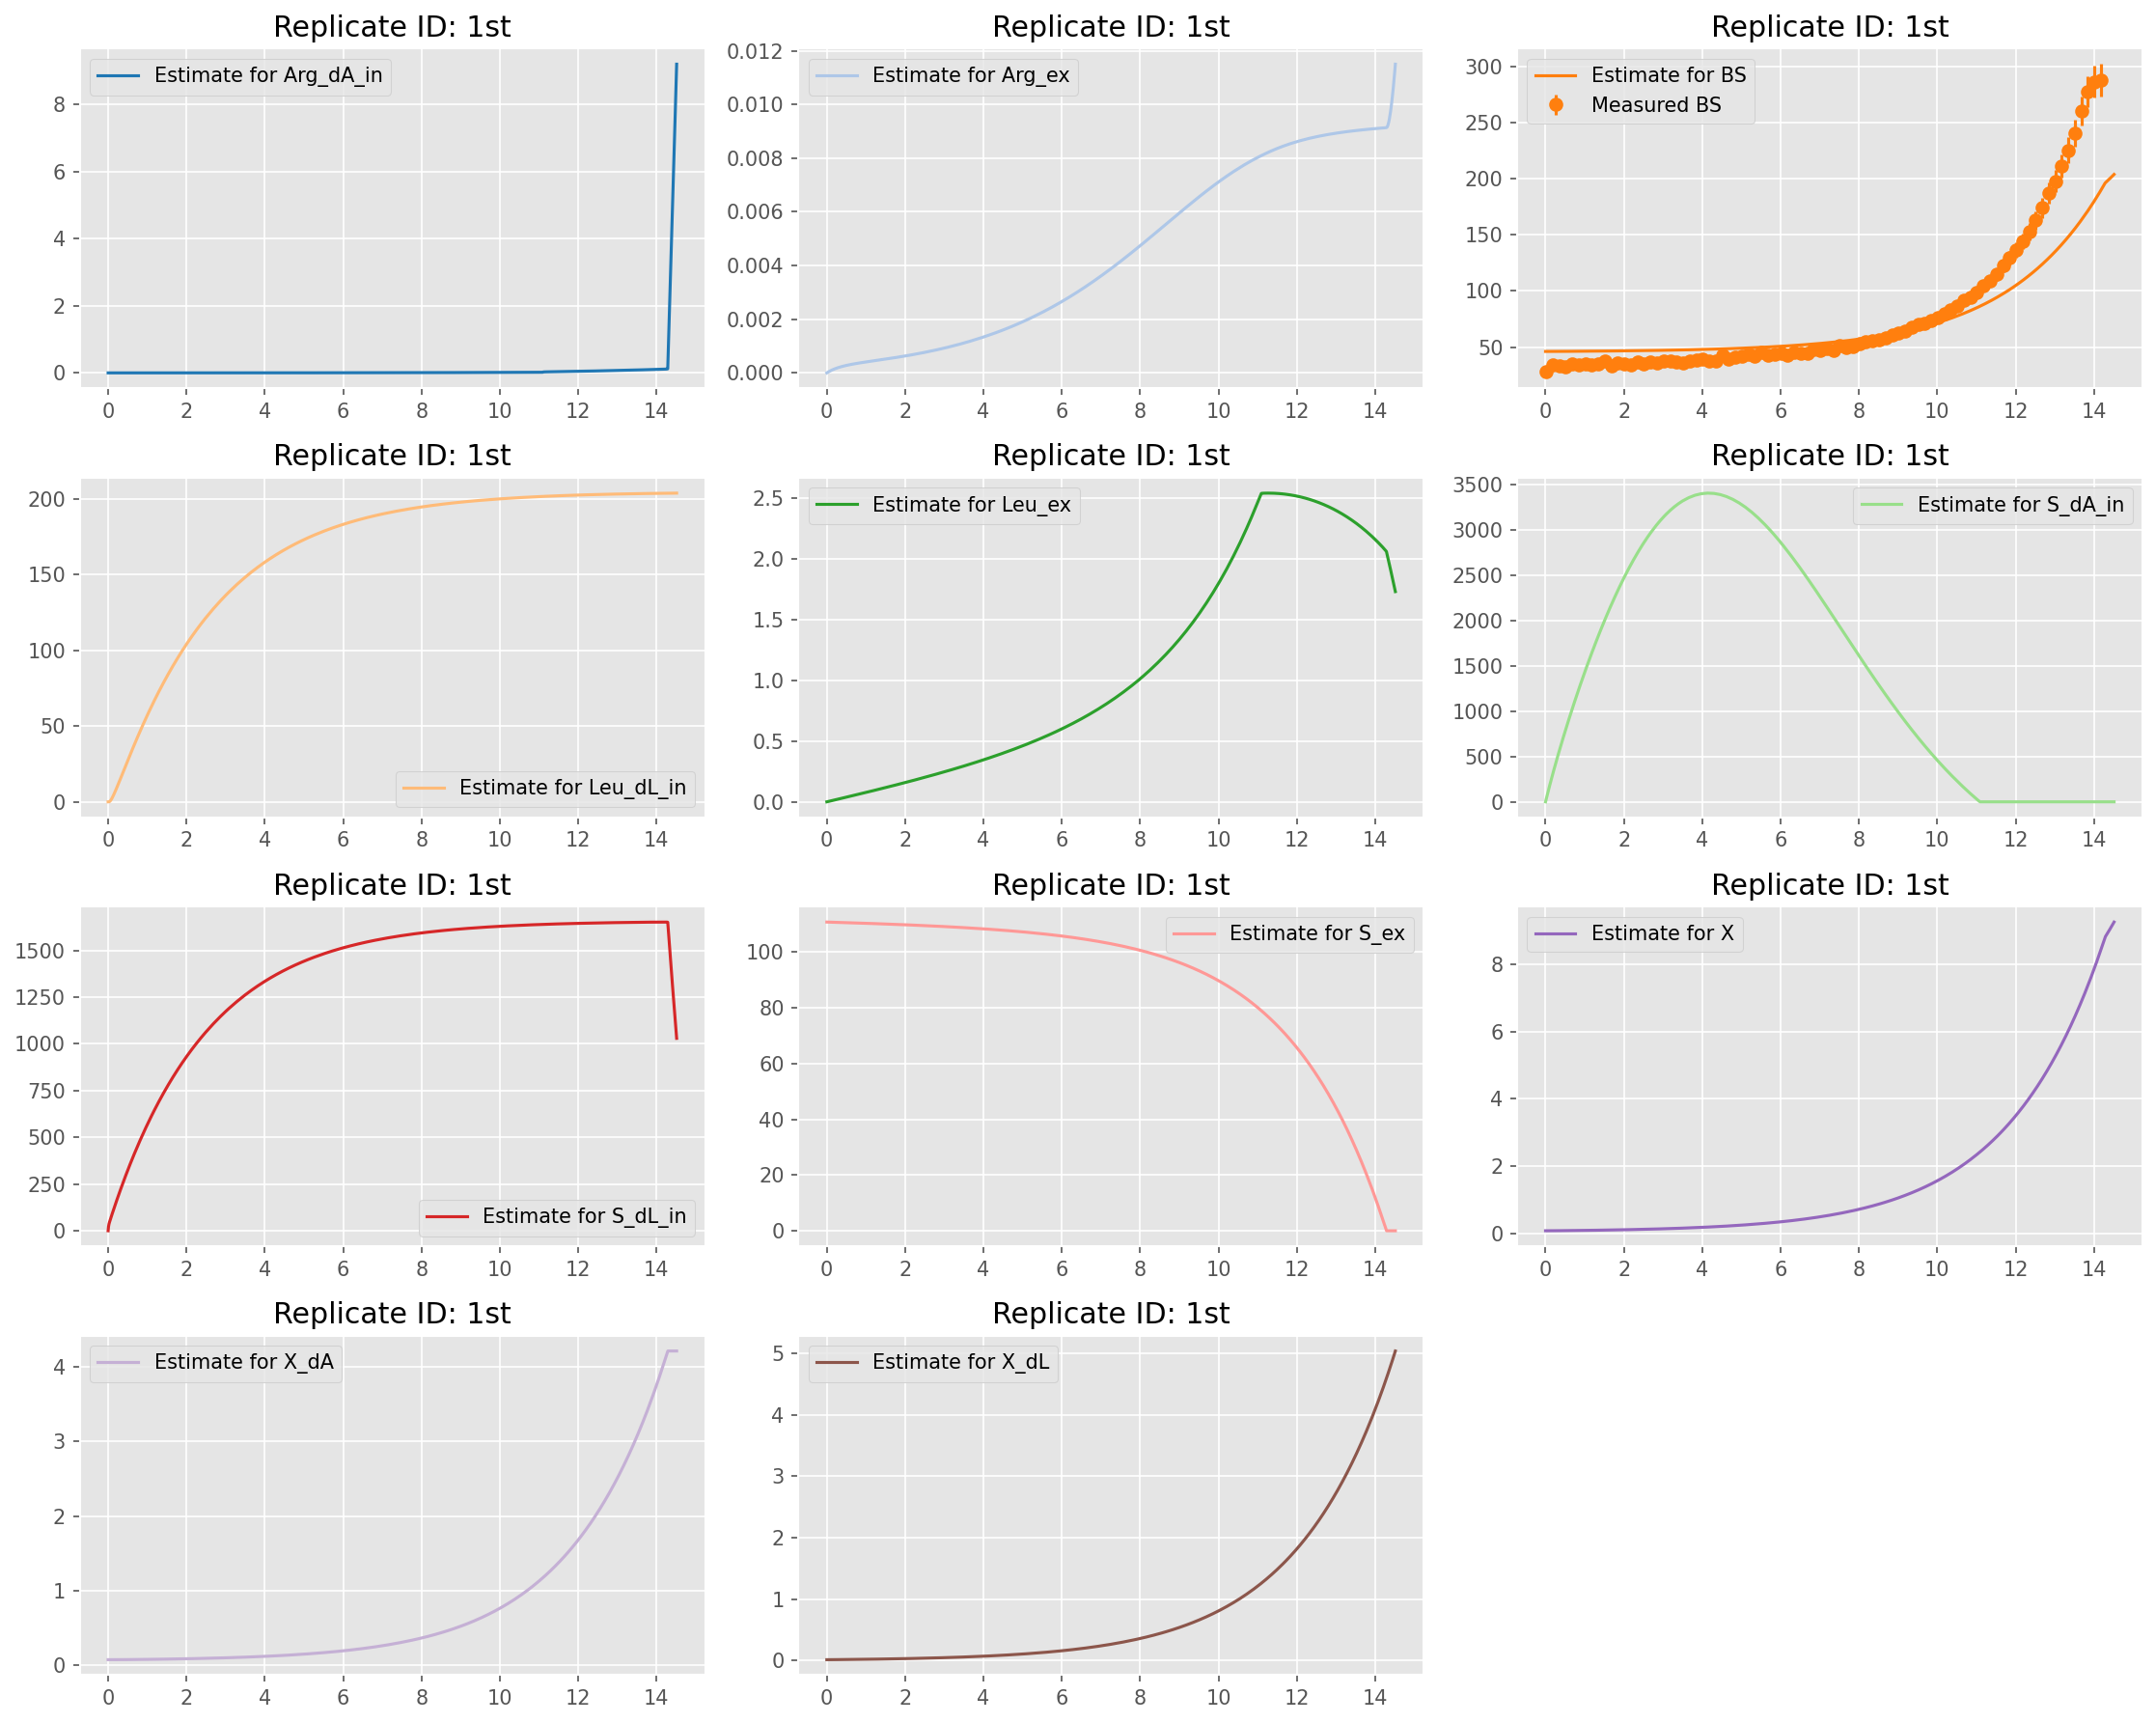

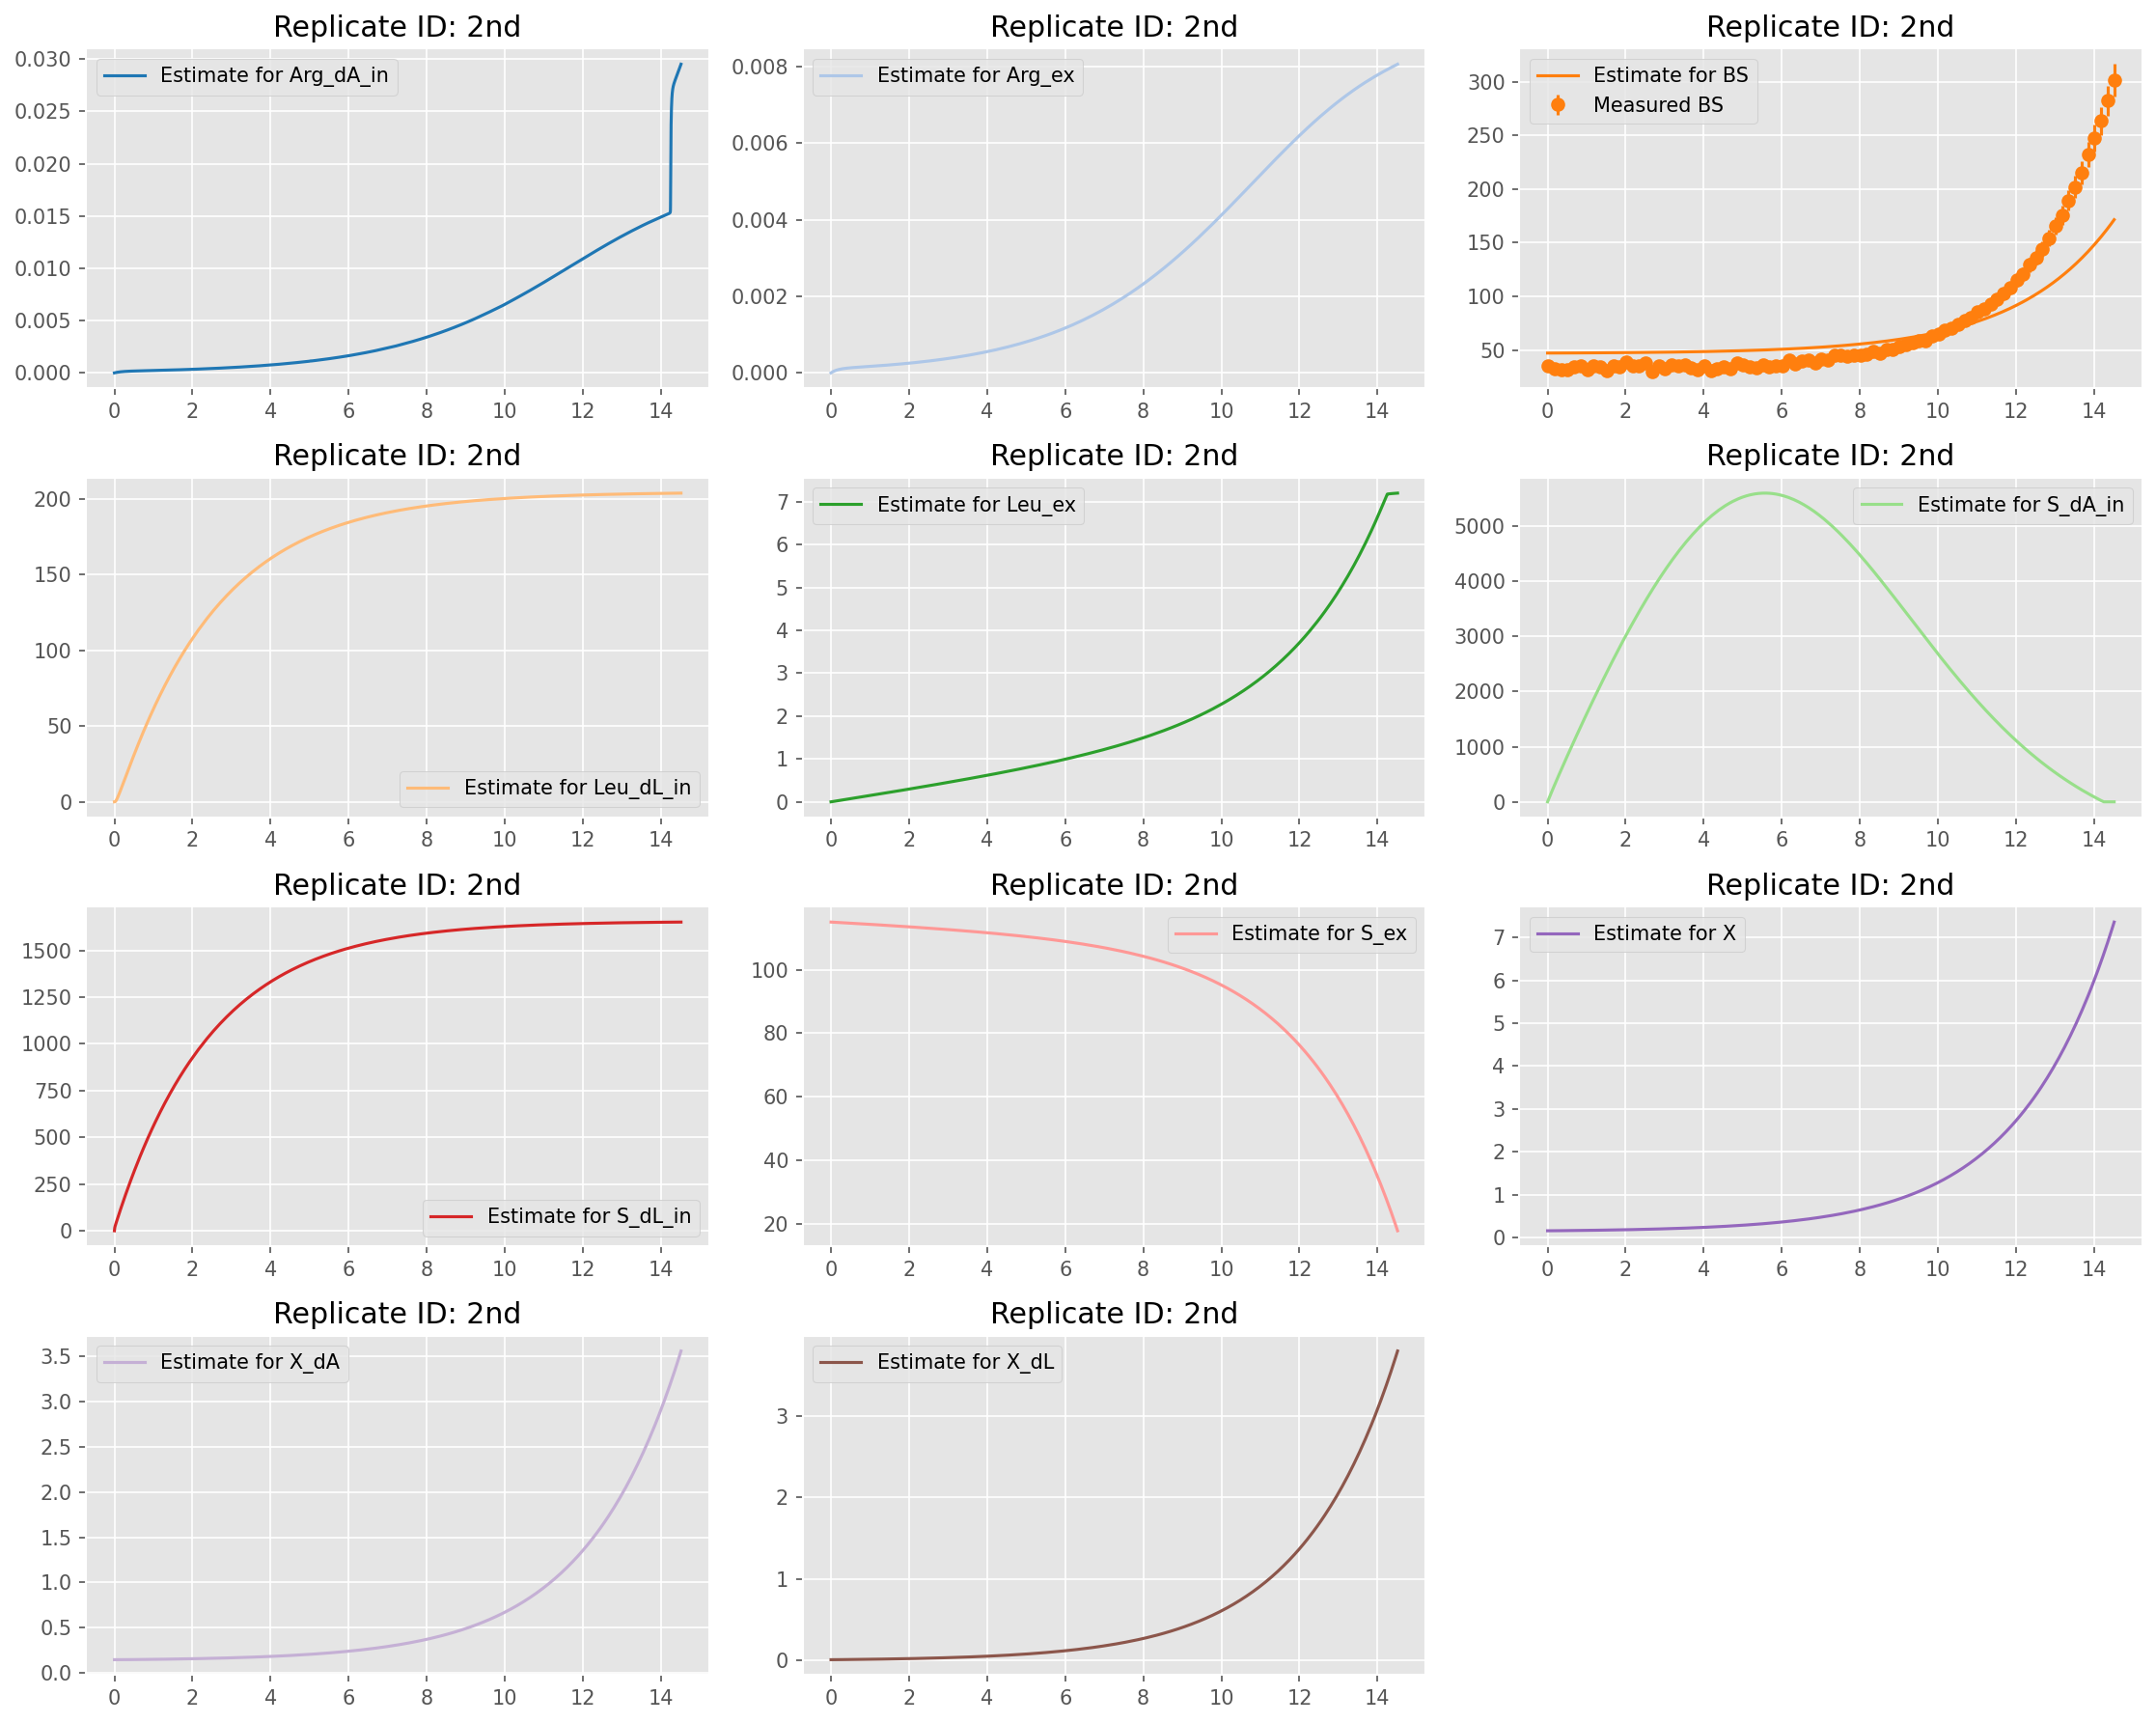

In [11]:
_fig3 = Visualization.compare_estimates(parameters=model_parameters, measurements=data, caretaker=conosModel)

## Define Unknowns

In [12]:
# Estimation bounds of model parameters are referring to MC-Sampling of single cultivations 
unknowns_and_bounds ={
#Initial Values (always estimate because of replicates)
    'X_dA0_R1'          : (0.0002              , 0.2),
    'X_dA0_R2'          : (0.0002              , 0.2),
    'X_dL0_R1'          : (0.0002              , 0.2),
    'X_dL0_R2'          : (0.0002              , 0.2),
    'X0_R1'             : (0.0003              , 0.4),
    'X0_R2'             : (0.0003              , 0.4),
    'S_ex0_R1'          : (70                  , 90),
    'S_ex0_R2'          : (70                  , 90),
#From 0_dARGLeu++.ipynb
    'K_mu_Arg_dA'       : (0.002423            , 0.002961),
    'v_syn_Leu_max_dA'  : (543.631526          , 632.258585),
    'mu_max_dA'         : (0.465068            , 0.487649),
#From 0_dLEUArg+.ipynb
    'mu_max_dL'         : (0.397038            , 0.409271),
    
#TO BE DETERMINED
    'a'                 : (0.001               , 0.50),
    'b'                 : (0.5                 , 3.5),
    'v_syn_Arg_max_dL'  : (80                  , 400),
    'K_syn_Arg_dL'      : (0.0015              , 0.08),
}

origin_bounds = unknowns_and_bounds

# 5. Function Definitions
## 5.1 Constrained Loss Calculator

Because pyFOOMB s designed for ODEs the algebraic equation 
$X = X_{\Delta LeuArg^{+}} + X_{\Delta ArgLeu^{++}}$
must be transformed into a differential equation [9]. Therefore, an additional initial condition for $X(t=0) = X_0$ is required.
With the help of the `ConstrainedLossCalculator`, constraints on the parameters can be imposed. This is used to ensure that the closure relation:


$X_{0} = X_{\Delta LeuArg^{+},0} + X_{\Delta ArgLeu^{++},0}$


is satisfied within a tolerance of $10^{-3}$. 

The super method `fitness` of LossCalculator needs to be overloaded. Instead of simply setting the loss to infinity if a constraint is violated, it now applies the quadratic penalty method to the objective function (loss function)

In [13]:
from typing import List
class ConstrainedLossCalculator(LossCalculator):
    
    #Overload method
    def fitness(self, x)-> List[float]:
        """
        Method for fitness calculation, as demanded by the pygmo package. 
        """

        # (1): Create the current parameter dictionary from the current guess vector
        self.current_parameters = x
        lam = 5e-9 #penalty parameter
        
        # Load Parameters
        X_dA0_R1   = self.current_parameters['X_dA0_R1']
        X_dL0_R1   = self.current_parameters['X_dL0_R1']
        X0_R1      = self.current_parameters['X0_R1']
        
        X_dA0_R2   = self.current_parameters['X_dA0_R2']
        X_dL0_R2   = self.current_parameters['X_dL0_R2']
        X0_R2      = self.current_parameters['X0_R2']
        
        # (2) Check if any constraint is violated
        constraints_ok = self.check_constraints()
        if not all(constraints_ok):
            loss = self.get_model_loss() + 1/(2*lam)*abs((X0_R1-(X_dA0_R1 + X_dL0_R1)))**2 + 1/(2*lam)*abs((X0_R2-(X_dA0_R2 + X_dL0_R2)))**2
            
        # (3) Evaluate the Caretakers objective function only is no constraints have been violated
        else:
            loss = self.get_model_loss()
            
        
        return [loss]
    
    def constraint_1(self) -> bool:
        X_dA0_R1   = self.current_parameters['X_dA0_R1']
        X_dL0_R1   = self.current_parameters['X_dL0_R1']
        X0_R1      = self.current_parameters['X0_R1']
        return np.allclose((X_dA0_R1 + X_dL0_R1), X0_R1, rtol=1e-9)
    
    def constraint_2(self) -> bool:
        X_dA0_R2   = self.current_parameters['X_dA0_R2']
        X_dL0_R2   = self.current_parameters['X_dL0_R2']
        X0_R2      = self.current_parameters['X0_R2']
        return np.allclose((X_dA0_R2 + X_dL0_R2), X0_R2, rtol=1e-9)    
    
    def check_constraints(self):
        con_1 = self.constraint_1()
        con_2 = self.constraint_2()
        return [con_1, con_2]
    

## 5.2 Adjust Bounds
Function to adjust the boundaries of the parameter estimation. Specifications are:

|Parameter        |Description                            |Default |
|-----------------|---------------------------------------|--------|
|estimates        |Current estimates as dict              | -      |
|original_bounds  |The bounds of the last estimation (bounds to alter)|unknowns_and_bounds|
|rel_width        |Relative value, used to narrow the bounds |5%|
|violation        |Alloable violation of the bounds per run |1%|
|vio_threshold    |relative distance from boundary until bounds are enlarged|0.5%|
|keep_X           |Determines if the bounds of X0 shall be altered as well or not |False|
|keep_PTD         |Altering bounds of the parameters to be determined? (a,b,v_syn_Leu)| True|

In [14]:
def adjust_bounds(estimates, original_bounds=unknowns_and_bounds, rel_width=0.05, violation=0.01, vio_threshold=5e-3, keep_X=False, keep_PTD=True):
    
    #initialize
    adj_bounds    = {}
    est_keys      = [str(item) for item in estimates.keys()]
    X0_keys       = [str(item) for item in estimates.keys() if str(item).startswith('X')]
         
    #Set multipliers based on given parameters
    tight_lo      = 1-rel_width
    tight_hi      = 1+rel_width
    vio_lo        = 1-violation
    vio_hi        = 1+violation
    
    #Apply keep X if specified
    if keep_X:
        key_list = list(set(est_keys)-set(X0_keys))
        for par in X0_keys:
            adj_bounds[par] = original_bounds[par]
    else:
        key_list = est_keys
        
    #Iterate over all parameters 
    for par in key_list:
        #Specify values for current parameter
        _lb      = original_bounds[par][0]
        _ub      = original_bounds[par][1]
        _est     = estimates[par]
        if (str(par) in ['a','b','v_syn_Arg_max_dL']) and keep_PTD:
            _est_u   = _ub
            _est_l   = _lb
        else:
            _est_u   = _est*tight_hi
            _est_l   = _est*tight_lo
        
        #Maintain parameters >0
        if _est_l <= 0:
            _est_l = 1e-6
        if _est_u <= 0:
            _est_u = 2e-6

        #CLOSE TO LOWER BOUND?
        if   ((_est-_lb)/np.mean([_est,_lb])) <= vio_threshold:
            _lb  = _lb * vio_lo
        

        #CLOSE TO UPPER BOUND?
        if ((_ub-_est)/np.mean([_est,_ub])) <= vio_threshold:
            _ub = _ub * vio_hi

        if _lb >= _ub:
            _lb, _ub = _ub, _lb
            
        if (_est_u <= _est_l):
           _est_u = _ub
           _est_l = _lb
                
        """Set tightened bounds concerning the newly set overall bounds"""
        #SATISFIED
        if (_est_l >= _lb) & (_est_u <= _ub):
            adj_bounds[par] = (_est_l, _est_u)
            
        #UPPER VIOLATED
        elif (_est_l >= _lb) & (_est_u > _ub):
            adj_bounds[par] = (_est_l, _ub)
            
        #LOWER VIOLATED
        elif (_est_l < _lb) & (_est_u <= _ub):
            adj_bounds[par] = (_lb, _est_u)
        
        #BOTH VIOLATED
        else:
            adj_bounds[par] = (_lb, _ub)
            
    return adj_bounds


## 5.3 Plot Bound violations and new bounds

This function plots the normalized bounds (blue line) as well as the changed normalized bounds (green bars). The parameters are plotted in a normalized manner (-100%,100%) as they deviate from the mean value of their bounds.

In [15]:
def plot_bound_violation(est, original_bounds=origin_bounds, new_bounds = unknowns_and_bounds):
  
    Y_percent = {}
    Y_ub      = {}
    Y_lb      = {}
    N_ub      = {}
    N_lb      = {}
    ind       = []
    
    for key in est.keys():
        Y_percent[key] = ((est[key]-original_bounds[key][0])/(original_bounds[key][1]-original_bounds[key][0])*100 -50)*2
        Y_ub[key]      = 100
        Y_lb[key]      = -100
        N_ub[key]      = ((new_bounds[key][1]-original_bounds[key][0])/(original_bounds[key][1]-original_bounds[key][0])*100 -50)*2
        N_lb[key]      = ((new_bounds[key][0]-original_bounds[key][0])/(original_bounds[key][1]-original_bounds[key][0])*100 -50)*2
        ind.append(str(key))

    plt.figure(figsize=(20, 10), dpi=80)

    p1 = plt.scatter(Y_percent.keys(),Y_percent.values())
    p2 = plt.plot(Y_ub.keys(),Y_ub.values(), 'b-.')
    p3 = plt.plot(Y_lb.keys(),Y_lb.values(), 'b-.')
    #p4 = plt.bar(.keys(),list(N_ub.values()), width=0.2, bottom=list(N_lb.values()), color='g')   
    p5 = plt.plot(N_ub.keys(),N_ub.values(),'g-')
    p6 = plt.plot(N_lb.keys(),N_lb.values(),'g-')
    
    plt.title('Parameter Bounds', fontsize=24)
    plt.xticks(ind, rotation=90, fontsize=18)
    plt.yticks([-200,-175,-150,-125,-100,-75,-50,-25,0,25,50,75,100,125,150,175,200], fontsize = 18)
    plt.show()
    
def show_violation_table(est, original_bounds=origin_bounds, new_bounds = unknowns_and_bounds):
    from IPython.display import display
    _table = {}
    for key in est.keys():
        _table[key] = [new_bounds[key][0], original_bounds[key][0], est[key], original_bounds[key][1], new_bounds[key][1]]
    
    ind   =['New LB','Lower Original Bound', 'Estimate', 'Upper Original Bound','New UB']
    table = pd.DataFrame(_table, index=ind)
    table = table.transpose()
    display(table)

## 5.4 Read and Write Bounds

In [16]:
def write_bounds(bounds:dict):
    np.save('bkp_bounds.npy',bounds)

def read_bounds(filename:str='bkp_bounds.npy'):
    return np.load(filename,allow_pickle='TRUE').item()

## 5.5 Check Optimizer Improvement

In [17]:
def check_last_improvement(cont_thres, est_info):
    #Read losses
    _current_best = est_info.best_loss_trail[len(est_info.best_loss_trail)-1]
    _last_best    = est_info.best_loss_trail[len(est_info.best_loss_trail)-2]
    
    #Decide on improvement
    if (_current_best > 10000000) or ((_last_best - _current_best) >= cont_thres):
        return True
    else:
        return False

## 5.6 Create Bounds from Estimate Backup

In [18]:
def bnd_from_backup(filename:str='estimates_bkp1.xlsx',save:bool=True, keep_X:bool=True):
    #Read, convert to dict, drop header
    _est = pd.read_excel(filename,index_col=0).to_dict().pop('Parameters')
    _bnd = adjust_bounds(
        estimates          =_est, 
        original_bounds    =origin_bounds, 
        rel_width          =0.05, 
        violation          =0.01, 
        vio_threshold      =5e-3, 
        keep_X             =keep_X)
    
    if save:
        write_bounds(_bnd)
    return _bnd

## 5.7 MC-Samples Evaluation Methods

In [36]:
def plot_rates(mc_data, conos=False, rates_only=True):
    # Distinguish plotsize if conos (more rates)
    if conos and rates_only:
        np = 4
    elif conos and (rates_only == False):
        np = 10
    elif (conos == False) and rates_only:
        np = 2
    else:
        np = 8

    # Initialize figure
    fig, ax_r = plt.subplots(np, 2)
    fig.set_size_inches(18, 4 * np)

    # Get rate-keys if specified
    if rates_only:
        rate_keys = [rate for rate in mc_data.keys() if (str(rate).startswith('v')) or (str(rate).startswith('mu'))]
    else:
        rate_keys = mc_data.keys()

    # initialize plot counters
    i, j = 0, 0

    # Plot all rates
    for rate_name in rate_keys:
        for r in mc_data[rate_name]:
            ax_r[i, j].plot(r[0], r[1], linewidth=0.1, color='red')
        ax_r[i, j].set_title(str(rate_name))
        ax_r[i, j].set_xlim(0, 18)
        ax_r[i, j].set_xlabel('Time [min]')
        if str(rate_name).startswith('mu'):
            ax_r[i, j].set_ylabel(str(rate_name) + ' [1/h]')
        elif str(rate_name).startswith('v'):
            ax_r[i, j].set_ylabel(str(rate_name) + ' [mmol/l_cell*h]')
        elif str(rate_name).startswith('BS'):
            ax_r[i, j].set_ylabel(str(rate_name) + ' [-]')
        elif str(rate_name).startswith('X'):
            ax_r[i, j].set_ylabel(str(rate_name) + ' [g/l]')
        else:
            ax_r[i, j].set_ylabel(str(rate_name) + ' [mmol/l]')
        # ax_r[i,j].plot(get_mean(mc_data[rate_name]).index,get_mean(mc_data[rate_name]).values,linewidth=1.5, color='black')

        if j == 0:
            i, j = i, j + 1
        else:
            i, j = i + 1, 0
            
    plt.subplots_adjust(
        left     = 0.1,
        right    = 0.9,
        bottom   = 0.1,
        top      = 0.9,
        wspace   = 0.4,
        hspace   = 0.4,
        
    )


def rate2df(data, rate):
    # Read rate from data
    _data = data[rate]

    # Initialize dict
    _df_list = []

    # Iterate trough mc-samples to fill the list with dataframes
    try:
        for mc in range(len(_data)):
            _df_list.append(pd.DataFrame(_data[mc][1], index=_data[mc][0]))
        keys = range(len(_data))
    except:
        for mc in range(2, len(_data) - 2):
            _df_list.append(pd.DataFrame(_data[mc][1], index=_data[mc][0]))
        keys = range(2, len(_data) - 2)
    # concatenate dataframes & drop unmatching rows
    _df = pd.concat(_df_list, axis=1).dropna().transpose()

    # assign mc_samples as keys
    return _df.reset_index().drop('index', axis=1).transpose()


def mode_comparison(mc_data1, mc_data2, conos=False, rates_only=False, colors: int = 0):
    # Distinguish plotsize if conos (more rates)
    if conos and rates_only:
        np = 4
    elif conos and (rates_only == False):
        np = 10
    elif (conos == False) and rates_only:
        np = 2
    else:
        np = 8

    # color list
    col_set = [['red', 'blue'], ['orange', 'green'], ['pink', 'black']]
    wdt_set = [0.1, 0.25, 0.7]

    # Initialize figure
    fig, ax_r = plt.subplots(np, 2)
    fig.set_size_inches(18, 4 * np)

    # Get rate-keys if specified
    if rates_only:
        rate_keys = [rate for rate in mc_data1.keys() if (str(rate).startswith('v')) or (str(rate).startswith('mu'))]
    else:
        rate_keys = mc_data1.keys()

    # initialize plot counters
    i, j = 0, 0

    # Plot all rates
    for rate_name in rate_keys:
        for r in mc_data1[rate_name]:
            ax_r[i, j].plot(r[0], r[1], linewidth=wdt_set[colors], color=col_set[colors][0])
        for s in mc_data2[rate_name]:
            ax_r[i, j].plot(s[0], s[1], linewidth=wdt_set[colors], color=col_set[colors][1])
        ax_r[i, j].set_title(str(rate_name))
        ax_r[i, j].set_xlim(0, 18)
        ax_r[i, j].set_xlabel('Time [h]')
        if str(rate_name).startswith('mu'):
            ax_r[i, j].set_ylabel(str(rate_name) + ' [1/h]')
        elif str(rate_name).startswith('v'):
            ax_r[i, j].set_ylabel(str(rate_name) + ' [mmol/l_cell*h]')
        elif str(rate_name).startswith('BS'):
            ax_r[i, j].set_ylabel(str(rate_name) + ' [-]')
        elif str(rate_name).startswith('X'):
            ax_r[i, j].set_ylabel(str(rate_name) + ' [g/l]')
        else:
            ax_r[i, j].set_ylabel(str(rate_name) + ' [mmol/l]')
        # ax_r[i,j].plot(get_mean(mc_data[rate_name]).index,get_mean(mc_data[rate_name]).values,linewidth=1.5, color='black')

        if j == 0:
            i, j = i, j + 1
        else:
            i, j = i + 1, 0
            
    plt.subplots_adjust(
        left     = 0.1,
        right    = 0.9,
        bottom   = 0.1,
        top      = 0.9,
        wspace   = 0.4,
        hspace   = 0.4,
        
    )
            
def conv2cell_unit(mc_data, rate: list = ['v_upt_S_dA', 'v_upt_S_dL', 'v_upt_Arg_dA', 'v_upt_Leu_dL', 'v_syn_Arg_dL',
                                          'v_syn_Leu_dA']):
    # Set constant conversion factor: specific cell volume
    V_cell = 1.93 / 1000

    # Initialize result list
    res = []

    # Substrate uptake dA
    if 'v_upt_S_dA' in rate:
        v_upt_S_dA = rate2df(mc_data, 'v_upt_S_dA')
        v_upt_S_dA = v_upt_S_dA.apply(lambda x: x * V_cell)
        res.append(v_upt_S_dA)

    # Substrate uptake dL
    if 'v_upt_S_dL' in rate:
        v_upt_S_dL = rate2df(mc_data, 'v_upt_S_dL')
        v_upt_S_dL = v_upt_S_dL.apply(lambda x: x * V_cell)
        res.append(v_upt_S_dL)

    # Arginine uptake dA
    if 'v_upt_Arg_dA' in rate:
        v_upt_Arg_dA = rate2df(mc_data, 'v_upt_Arg_dA')
        v_upt_Arg_dA = v_upt_Arg_dA.apply(lambda x: x * V_cell)
        res.append(v_upt_Arg_dA)

    # Leucine uptake dL
    if 'v_upt_Leu_dL' in rate:
        v_upt_Leu_dL = rate2df(mc_data, 'v_upt_Leu_dL')
        v_upt_Leu_dL = v_upt_Leu_dL.apply(lambda x: x * V_cell)
        res.append(v_upt_Leu_dL)

    # Arginine production dL
    if 'v_syn_Arg_dL' in rate:
        v_syn_Arg_dL = rate2df(mc_data, 'v_syn_Arg_dL')
        v_syn_Arg_dL = v_syn_Arg_dL.apply(lambda x: x * V_cell)
        res.append(v_syn_Arg_dL)

    # Arginine production dL
    if 'v_syn_Leu_dA' in rate:
        v_syn_Leu_dA = rate2df(mc_data, 'v_syn_Leu_dA')
        v_syn_Leu_dA = v_syn_Leu_dA.apply(lambda x: x * V_cell)
        res.append(v_syn_Leu_dA)

    return res

# 6. Parameter Estimation

### Working Optimizers:
* ihs 
* compass_search
* sea (problems with 2nd initialization -> only for manual use)
* de1220 (uses lots of RAM -> low number of evos)
* ihs (few exceptions)
* mbh (huge memory usage)

## 6.1 Setup for Estimator

In [20]:
#Used Optimizers
optimizers          = ['sea','sea','de1220','de1220','ihs','compass_search']    # Name doubling to use more of these 

#Used Threads
mult                = int(joblib.cpu_count()/len(optimizers))

#Relative Tolerance Islands
rtol                = 1e-3

restart             = True   # Set False if restarting from previous bounds
runs                = 1      # number of bound changes during one execution (restarting recommended)
evolutions          = 3      # minimum 2
evolutions_continued= 2      # Additional evolutions if improvement was discovered
cont_thres          = 100    # Threshold for continuing estimation
max_evotime         = 14     

## 6.2 Call Estimator


 
 
 ----------------

Starting Run No.1 ...
Creating archipelago with 12 islands. May take some time...


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:   25.0s remaining:  2.1min
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   34.2s finished


Running 1 evolutions for all 12 islands of the archipelago...

-------------Finished evolution 1-------------
Current best loss: 278162.92413862806
Average loss among the islands: 439910.822122 +/- 136643.909583 (31.061729 %)
Run time for this evolution was 2.15 min

Completed 1 evolution runs.

Estimated parameters:
a: 0.0544346056572265
b: 1.170366580174222
K_mu_Arg_dA: 0.002909316451829835
K_syn_Arg_dL: 0.058308677647376544
mu_max_dA: 0.4740041058018702
mu_max_dL: 0.40857554143406893
S_ex0_R1: 86.12086588198818
S_ex0_R2: 85.51656680076843
v_syn_Arg_max_dL: 233.7166459934859
v_syn_Leu_max_dA: 598.5095313059319
X0_R1: 0.12428269847179524
X0_R2: 0.046899007789004826
X_dA0_R1: 0.055778621576955435
X_dA0_R2: 0.03884768639968605
X_dL0_R1: 0.03834846788191335
X_dL0_R2: 0.015805900999222623

-------------Finished evolution 1-------------
Current best loss: 278162.92413862806
Average loss among the islands: 439910.822122 +/- 136643.909583 (31.061729 %)

Total runtime was 2.73 min

Running ad

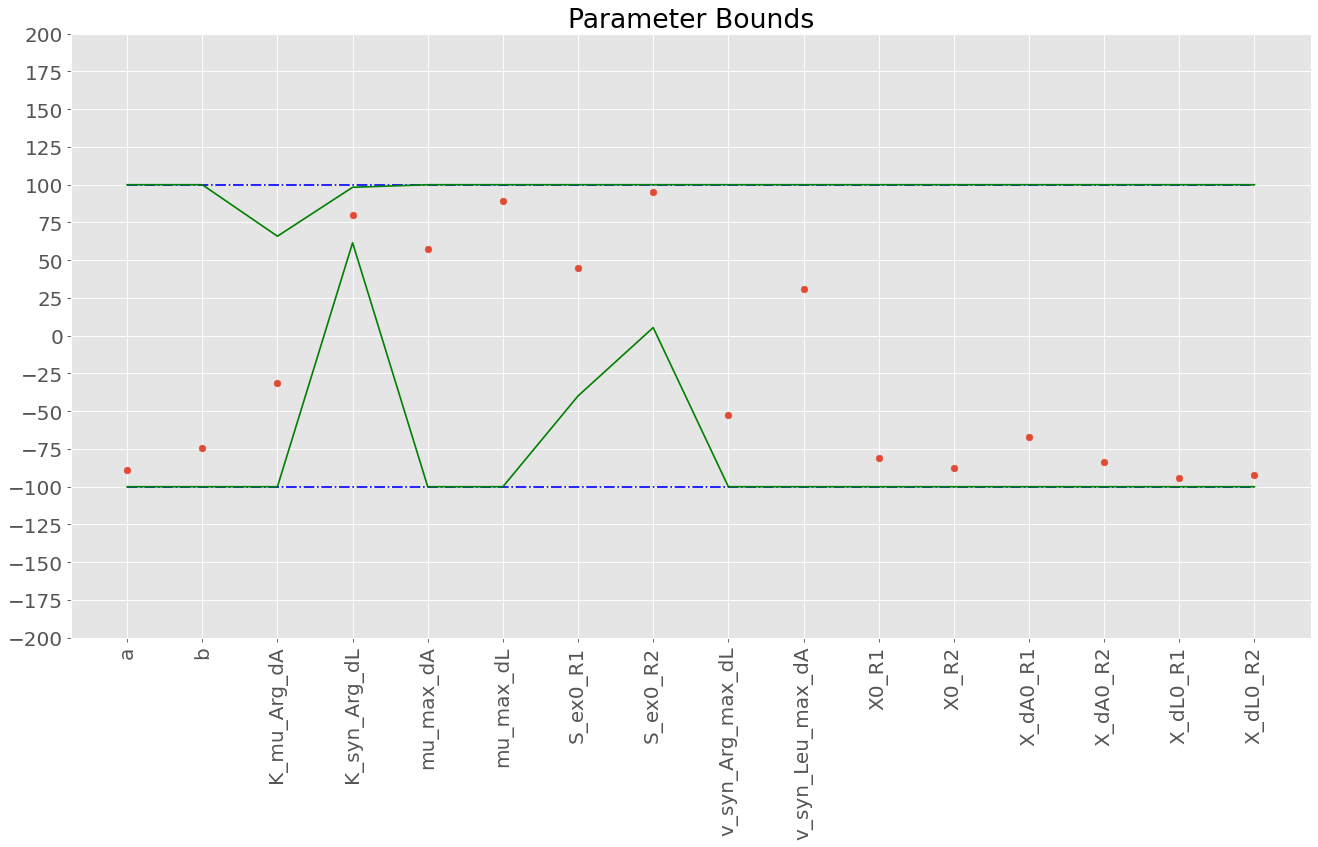

Difference in R1: 0.0006656094599697552 
 Difference in R2: -0.0011402545622148392


In [21]:
# If restart is set false: search file with boundaries
if not restart:
    try:
        unknowns_and_bounds = read_bounds()
        print('Continuing from previous bounds...')

    except FileNotFoundError:
        print('No backup file for bounds found. \nRestarting...')

for i in range(1,1+runs):
    print('\n \n \n ----------------')
    print('\nStarting Run No.{} ...'.format(i))
    #1. Estimate
    estimates, est_info = conosModel.estimate_parallel(
        unknowns        = list(unknowns_and_bounds.keys()), 
        bounds          = list(unknowns_and_bounds.values()), 
        measurements    = data, 
        report_level    = 5,
        optimizers      = optimizers*mult,
    #        max_evotime_min = max_evotime,
        metric          = 'SS', 
        rtol_islands    = rtol,
        evolutions      = 1,
        loss_calculator = ConstrainedLossCalculator
        )
    #Changing pygmos (subpackage of pyFOOMB) migrant handling
    from pygmo import core
    e = core.migrant_handling.evict
    est_info.archipelago.set_migrant_handling(e)
    
    estimates, est_info     = conosModel.estimate_parallel_continued(
        estimation_result   = est_info,
        report_level        = 5,
        max_evotime_min     = max_evotime,
        rtol_islands        = rtol,
        evolutions          = evolutions-1,
        )
    
    dR1 = estimates['X0_R1'] - estimates['X_dA0_R1'] - estimates['X_dL0_R1']
    dR2 = estimates['X0_R2'] - estimates['X_dA0_R2'] - estimates['X_dL0_R2']
    print('Difference in R1: {} \nDifference in R2: {}'.format(dR1, dR2))
    
    #Backup for results
    estimates_df = pd.DataFrame(estimates, index=['Parameters']).transpose().to_excel('estimates_bkp'+str(i)+'.xlsx')
    
    #2. Calculate LossCalculators Constraint satisfaction
    dR1 = estimates['X0_R1'] - estimates['X_dA0_R1'] - estimates['X_dL0_R1']
    dR2 = estimates['X0_R2'] - estimates['X_dA0_R2'] - estimates['X_dL0_R2']
    
    #3. Do additional evolutions if improvement is possible
    while check_last_improvement(cont_thres, est_info):
       
        estimates, est_info = conosModel.estimate_parallel_continued(
        estimation_result   =est_info,
        report_level        = 5,
        max_evotime_min     = max_evotime,
        rtol_islands        = rtol,
        evolutions          = evolutions_continued,
        )
        #Backup
        estimates_df = pd.DataFrame(estimates, index=['Parameters']).transpose().to_excel('estimates_bkp'+str(i)+'.xlsx')
     

    
    #5. Adjust bounds
    if max(abs(dR1),abs(dR2)) <= 1e-3:
        print('Difference in R1: {} \nDifference in R2: {}'.format(dR1, dR2))
        print('----- \nAdjusting Bounds with X0 to 5% interval allowing 2% violation of bounds')
        unknowns_and_bounds = adjust_bounds(
            estimates,
            original_bounds = unknowns_and_bounds,
            rel_width       = 0.1,
            violation       = 0.0,
            vio_threshold   = 1e-2,
            keep_X          = False,
        )
        #Create Backup of bounds
        write_bounds(unknowns_and_bounds)
        
    #together with X0 if constraint is satisfied
    else:
        print('Difference in R1: {} \nDifference in R2: {}'.format(dR1, dR2))
        print('----- \nAdjusting Bounds to 8% interval allowing 1% violation of bounds keeping X0 bounds')
        unknowns_and_bounds = adjust_bounds(
            estimates,
            original_bounds = unknowns_and_bounds,
            rel_width       = 0.1,
            violation       = 0.0,
            vio_threshold   = 5e-2,
            keep_X          = True,
        )
        #Create Backup of bounds
        write_bounds(unknowns_and_bounds)

        
    plot_bound_violation(estimates, original_bounds=origin_bounds, new_bounds = unknowns_and_bounds)

print('Difference in R1: {} \n Difference in R2: {}'.format(dR1, dR2))

## 6.3 Visualize Results
Results after only one run (multiple runs required to also satisfy $X_0$ condition)

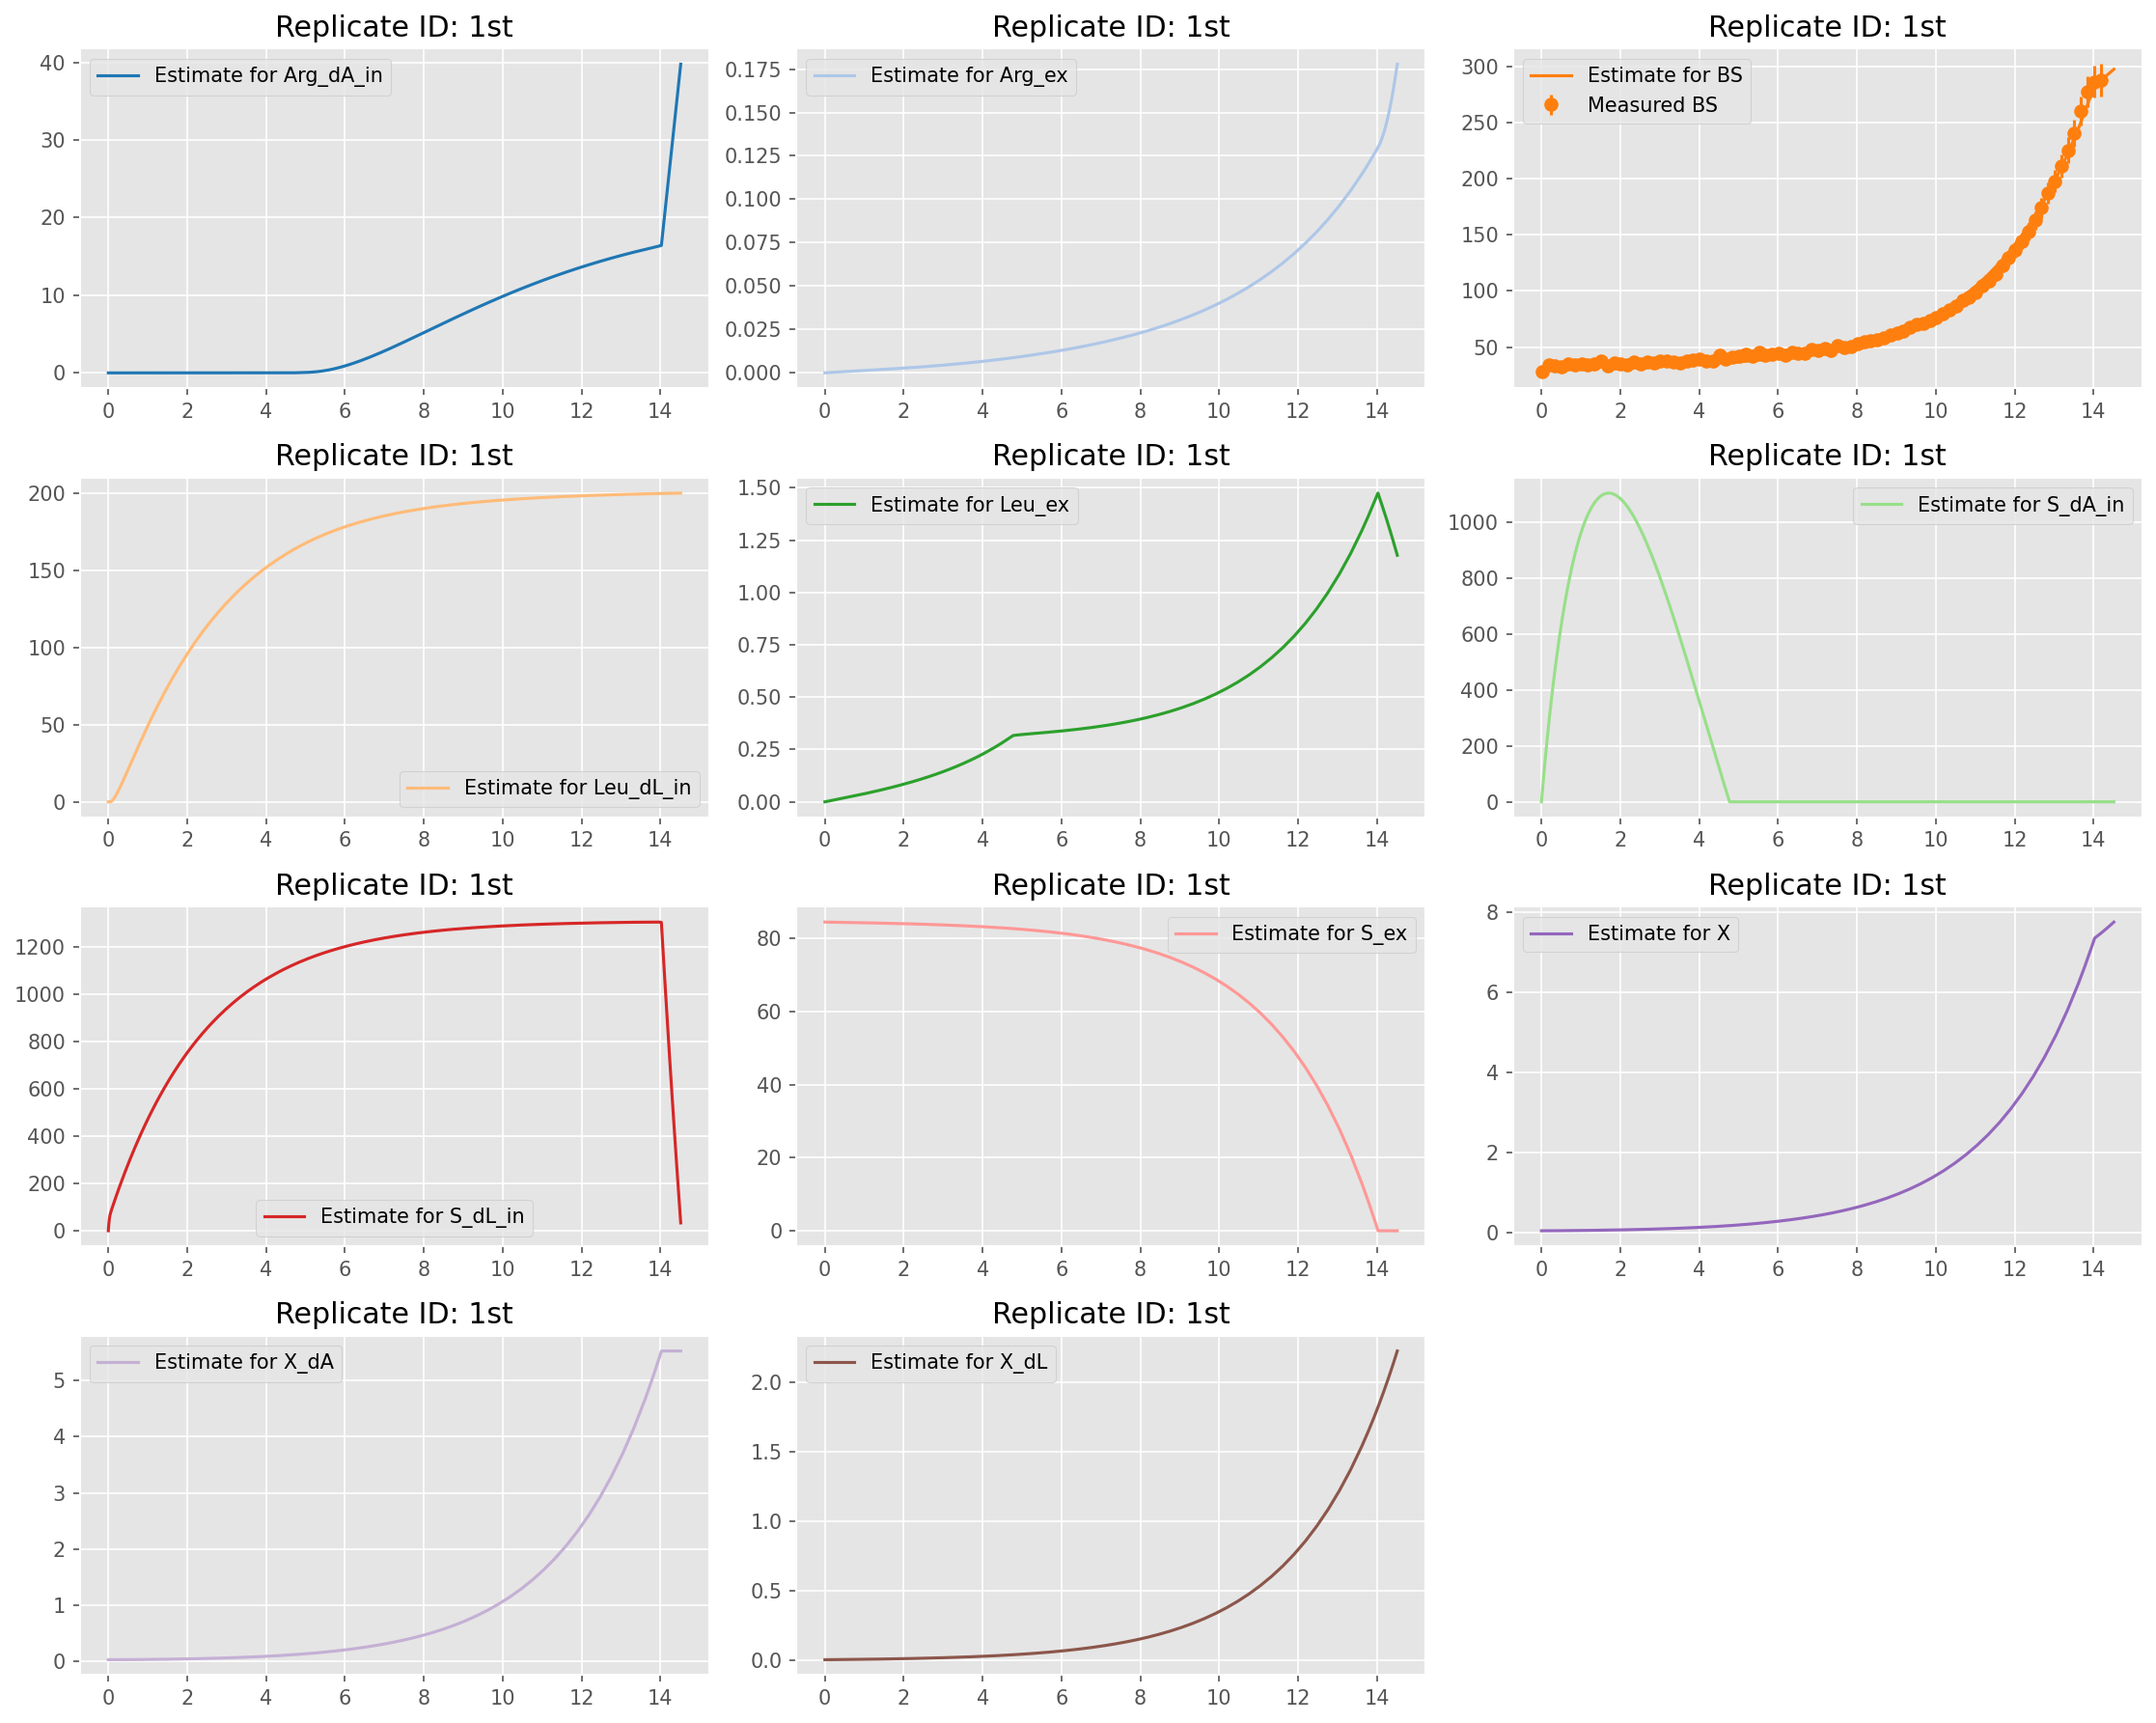

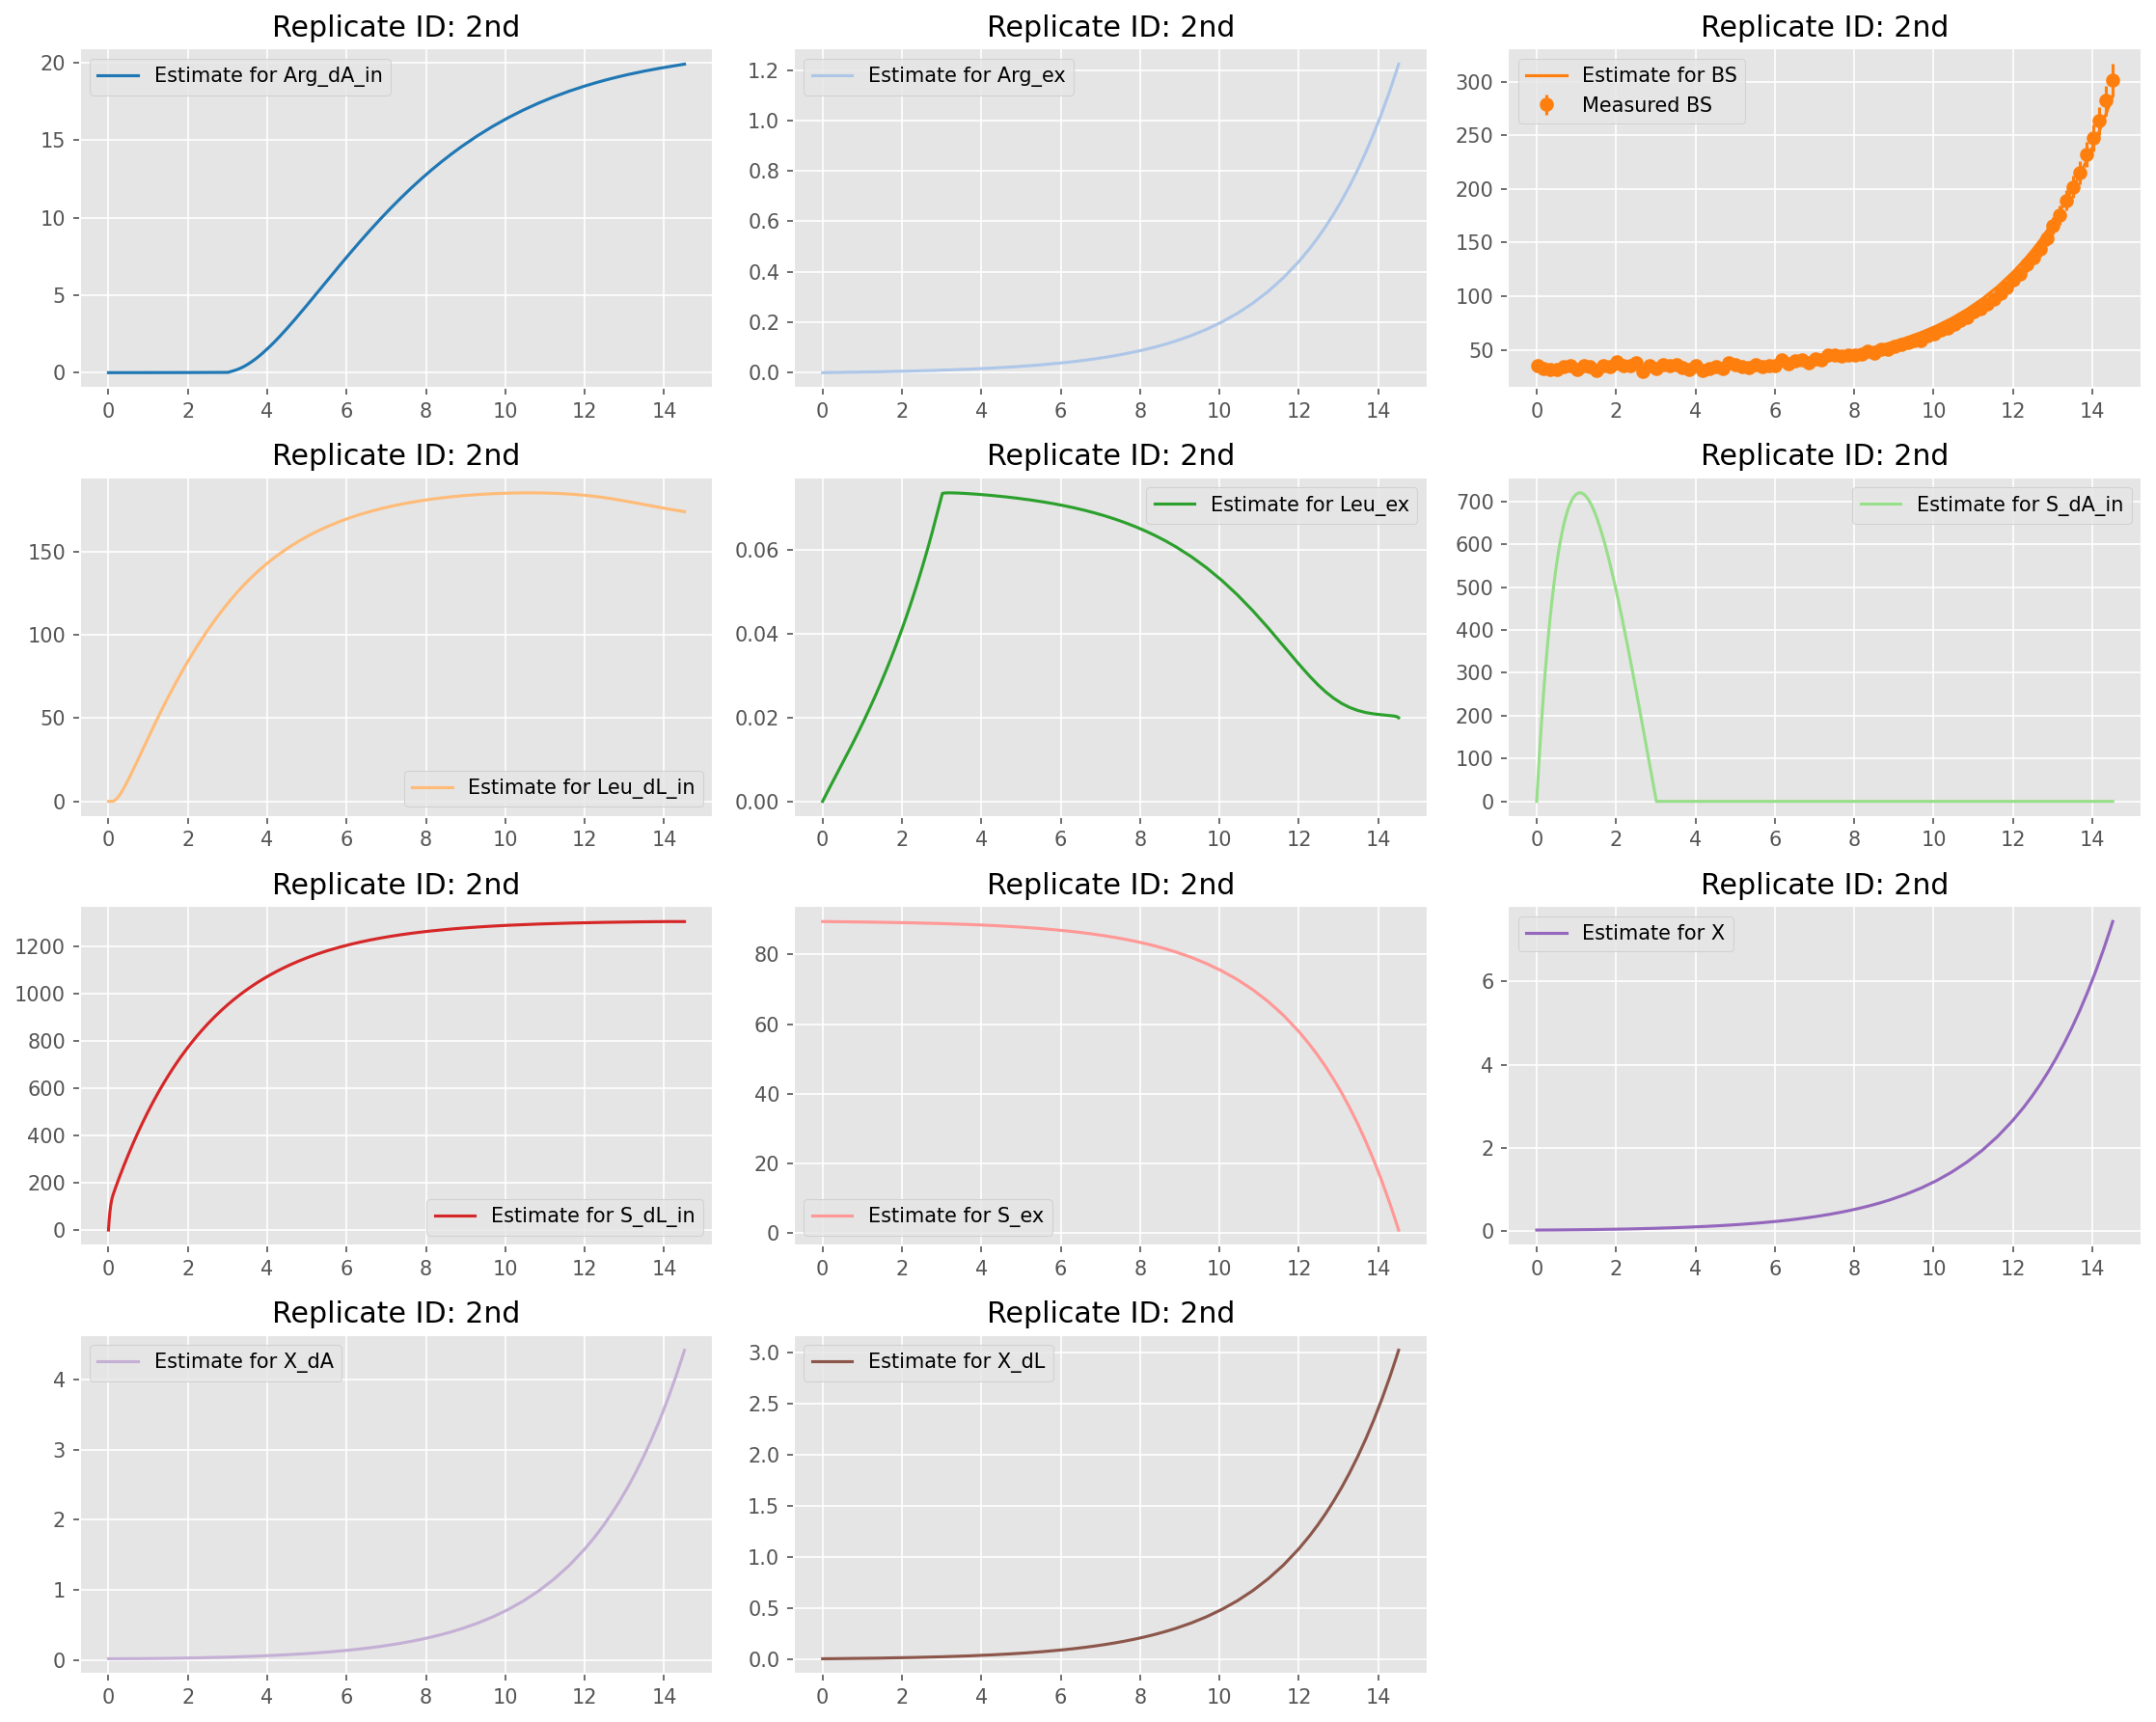

In [22]:
_fig4 = Visualization.compare_estimates(parameters=estimates, measurements=data, caretaker=conosModel)

# 7 Monte Carlo Sampling

## 7.1 Calculate / Read MC Samples
Monte Carlo sampling left out because of high calculation time. Due to very high RAM usage, only 4 samples at a time can be calculated. To automate this process the following code can be used:
https://stackoverflow.com/questions/54886701/how-to-code-restart-kernel-and-run-all-in-button-for-python-jupyter-notebook (last checked:05.02.22)

In [23]:
#estimates  = conosModel.estimate_parallel_MC_sampling(
#        unknowns=list(unknowns_and_bounds.keys()), 
#        bounds=list(unknowns_and_bounds.values()), 
#        measurements=data, 
#        report_level=5,
#        optimizers=optimizers*2,
#        metric='SS', 
#        rtol_islands=rtol,
#        evolutions=evolutions,
#        mc_samples=4,
#        loss_calculator=ConstrainedLossCalculator
#    )
#i=1
#while Path.isfile('Conos_MC_sup_bkp'+str(i)+'.xlsx'):
#    i+=1
#    
#estimates.to_excel('Conos_MC_sup_bkp'+str(i)+'.xlsx')

Because of the wide sampling space the MC samples need to be presorted. In the following evaluation, samples, which don't satisfy the $X_0$-constraint, and samples, which do not satisfy the final backscatter signal, have been sorted out.

In [24]:
mc_samples = pd.read_excel('CoNoS_dARG_LEU++_dLEU_ARG++_results_MC.xlsx', index_col=0).reset_index().drop('index', axis=1)

## 7.2 Calculate Rates for all MC Samples

In [25]:
# Simulating rates for all MC samples
parameter_slices = Helpers.split_parameters_distributions(mc_samples)

# initialize list for saving simulations
sim_many         = []

# Fix timepoint-vector
t = np.linspace(0, 35, 600)

for _par in parameter_slices:
    # Set current parameters and run forward simulation
    conosModel.set_parameters(_par)
    _sim = conosModel.simulate(t=t, parameters=_par)

    # Now calculate all specific rates TimeSeries objects
    specific_rates = []
    for rid in conosModel.replicate_ids:
        specific_rates.extend(
            conosModel.simulators[rid].bioprocess_model.get_specific_rates_time_series(_sim)
        )

    simulation_extended = [*_sim, *specific_rates]
    sim_many.append(simulation_extended)

# Sort Data into RIDs
rep1 = {}
rep2 = {}

# Easier format for data handling 
for mcs in range(len(sim_many)):
    for rate in sim_many[mcs]:
        if rate.replicate_id == '1st':
            if rate.name not in rep1.keys():
                rep1[rate.name] = []
                rep1[rate.name].append([rate.timepoints, rate.values])
            else:
                rep1[rate.name].append([rate.timepoints, rate.values])
        if rate.replicate_id == '2nd':
            if rate.name not in rep2.keys():
                rep2[rate.name] = []
                rep2[rate.name].append([rate.timepoints, rate.values])
            else:
                rep2[rate.name].append([rate.timepoints, rate.values])

## 7.3 Plot all Rates / Distinguish Modes

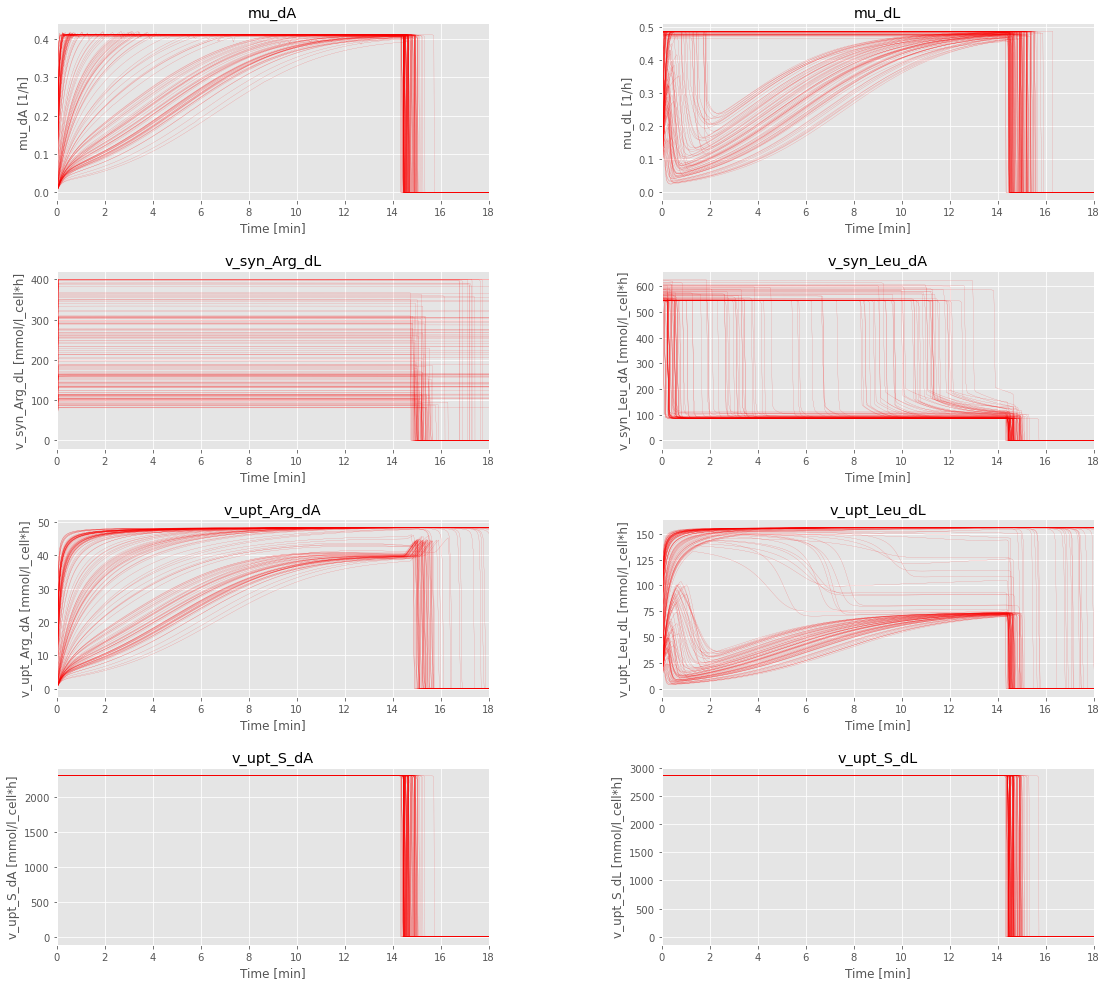

In [37]:
# For replicate 2
plot_rates(rep2, conos=True)

From the trajectory of $\mu_{\Delta LeuArg^{++}}$ (=`mu_dL`) as well as the Leucine uptake, we can identify two distinct modes as:

$\mu_{\Delta LeuArg^{++}}^{[1]}(t=6)<=0.42$

$\mu_{\Delta LeuArg^{++}}^{[2]}(t=3)<=0.4$

If we slice the rates accordingly, the modes can be further investigated for plausibility (only replicate 2 shown for brevity):

In [27]:
CN2_mode1  = {}
CN2_mode2  = {}

#Get approximate index of timepoints
t_real_1  = 6
t_real_2  = 3
t_event_1 = int((t_real_1 / max(rep1['mu_dL'][2][0])) * len(rep1['mu_dL'][2][0]))
t_event_2 = int((t_real_2 / max(rep2['mu_dL'][2][0])) * len(rep2['mu_dL'][2][0]))

for key in rep1.keys():
    for mc in range(len(rep1[key])):

        if (rep2['mu_dL'][mc][1][t_event_2] <=.4):
            try:
                CN2_mode1[key].append(rep2[key][mc])
            except:
                CN2_mode1[key] = rep2[key][mc]
            #print(mc)
           # print(len(CN1_mode1[key]))
        else:
            try:
                CN2_mode2[key].append(rep2[key][mc])
            except:
                CN2_mode2[key] = rep2[key][mc] 

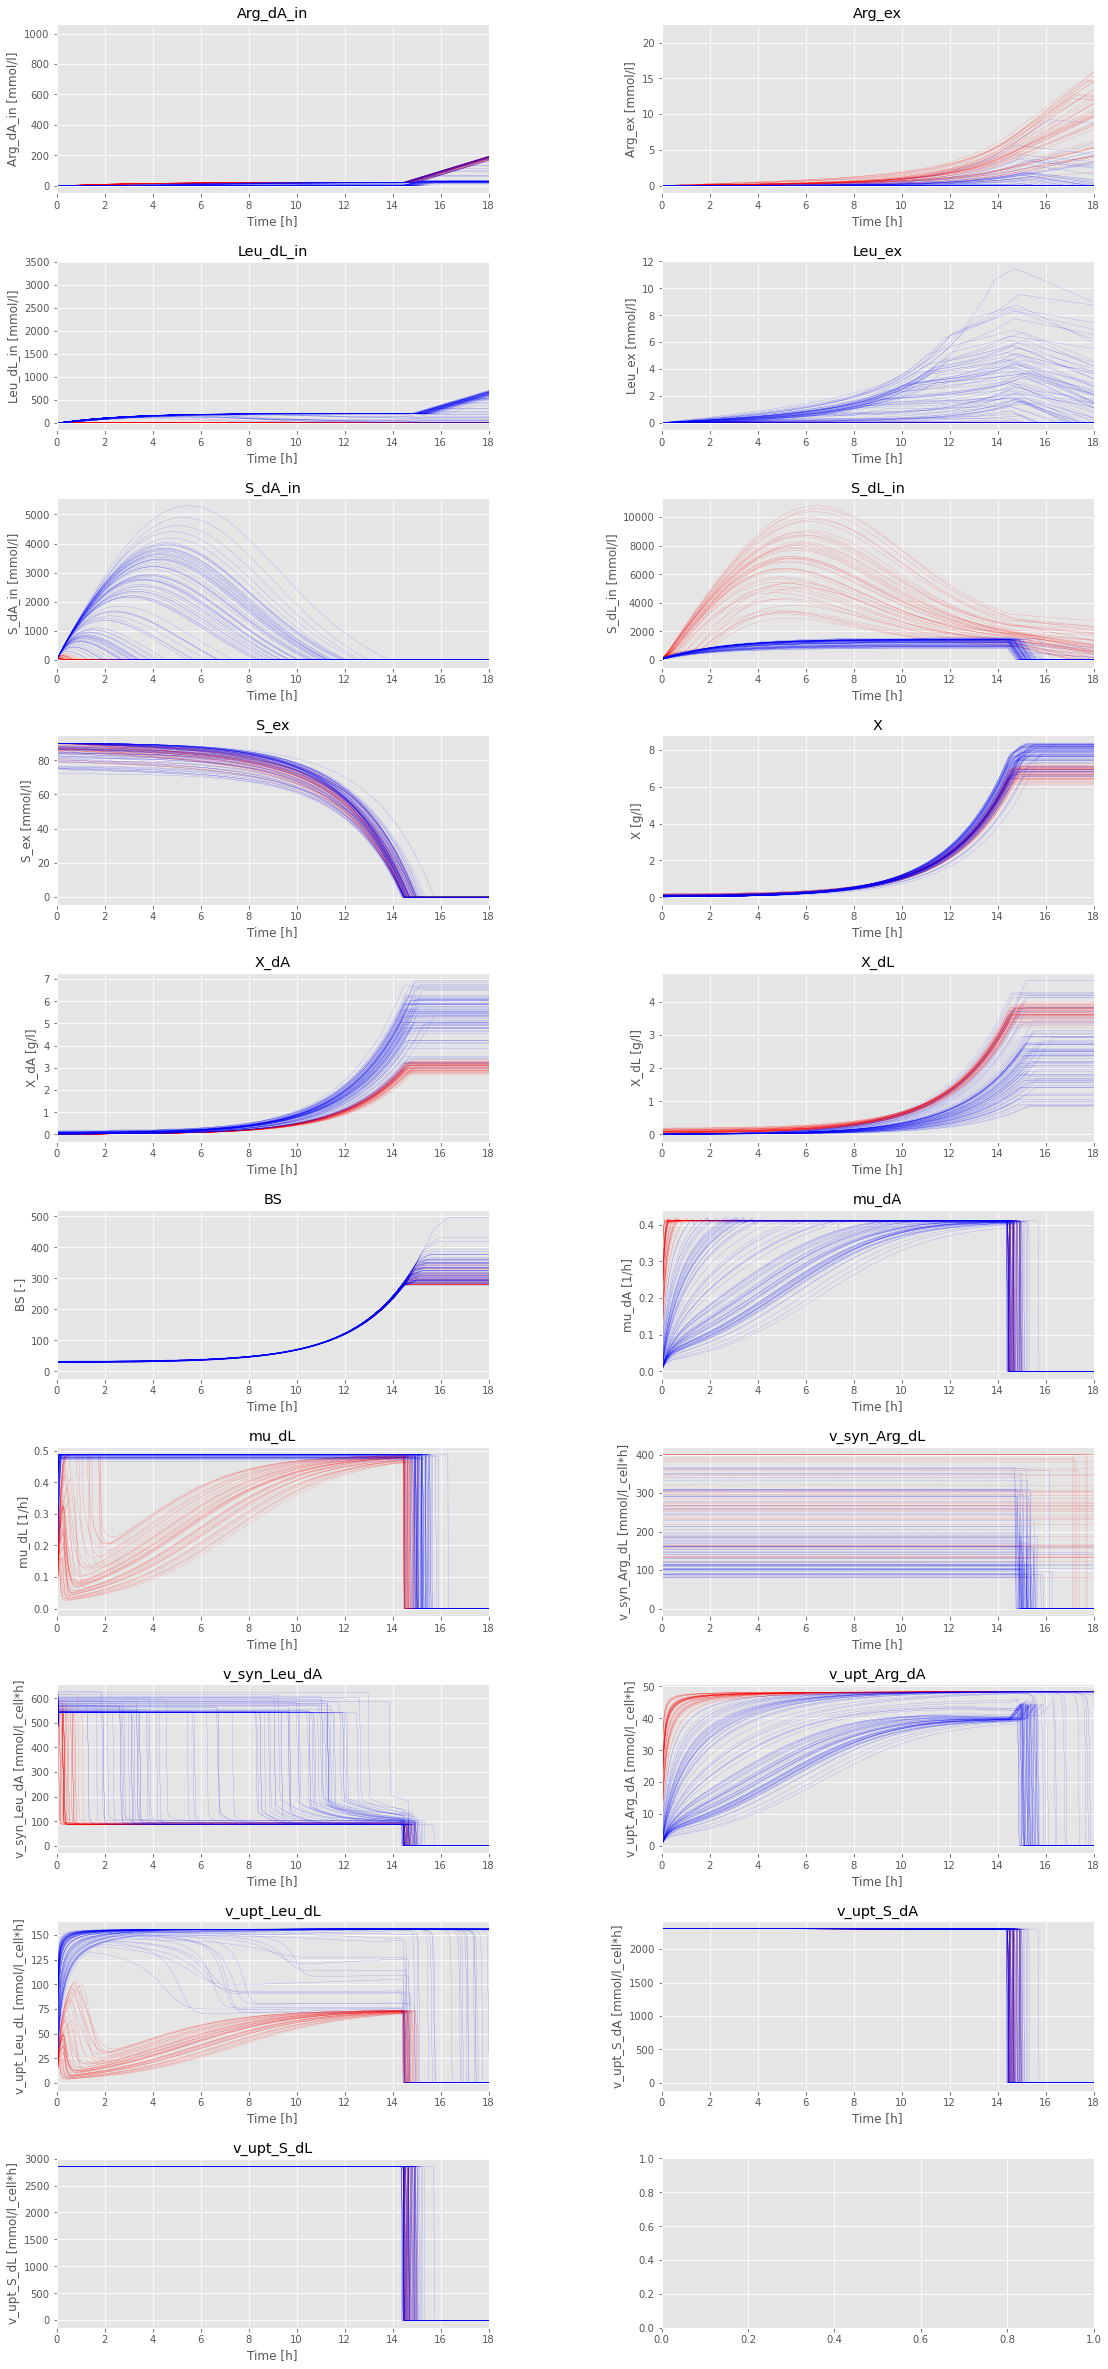

In [38]:
mode_comparison(CN2_mode1, CN2_mode2, conos=True, colors=0)

While mode 1 (red) implies a limitation of the dLeuArg strain by a very high arginine production, mode 2 implies a limitation of the dArgLeu strain by a slower arginine production. Accordingly, the ratios of the respective strains biomass differ. Based on the results of the previous parameter estimations, the rates for the leucine synthesis are up to five times higher than in the supplementation experiments with the exact same strain. This makes mode 1 more likely.

For the final evaluation of the rates of mode 1, only samples satisfying both the condition for rep1 and rep2 are used.

In [29]:
keep_ind  = []
CN1_mode1 = {}
CN2_mode1 = {}

#Get approximate index of timepoints
t_real_1  = 6
t_real_2  = 3
t_event_1 = int((t_real_1 / max(rep1['mu_dL'][2][0])) * len(rep1['mu_dL'][2][0]))
t_event_2 = int((t_real_2 / max(rep2['mu_dL'][2][0])) * len(rep2['mu_dL'][2][0]))


for mc in range(len(rep1['mu_dL'])):
    if (rep1['mu_dL'][mc][1][t_event_1] >.42) or (rep2['mu_dL'][mc][1][t_event_2] >.4):
        pass
    else:
        keep_ind.append(mc)
for key in rep1.keys():
    for mc in keep_ind:
        try:
            CN1_mode1[key].append(rep1[key][mc])
        except:
            CN1_mode1[key] = []
            CN1_mode1[key].append(rep1[key][mc])
            
for key in rep2.keys():
    for mc in keep_ind:
        try:
            CN2_mode1[key].append(rep2[key][mc])
        except:
            CN2_mode1[key] = []
            CN2_mode1[key].append(rep2[key][mc])

## 7.4 Evaluate Rates and Uncertainties

### Convert units and use timepoint t=12h

In [30]:
#Convert units to per gdw
CN1_c = conv2cell_unit(CN1_mode1)
CN1_c.append(rate2df(CN1_mode1,'mu_dA'))
CN1_c.append(rate2df(CN1_mode1,'mu_dL'))
CN1_c.append(rate2df(CN1_mode1,'X_dA'))
CN1_c.append(rate2df(CN1_mode1,'X_dL'))
CN1_c.append(rate2df(CN1_mode1,'X'))
CN2_c = conv2cell_unit(CN2_mode1)
CN2_c.append(rate2df(CN2_mode1,'mu_dA'))
CN2_c.append(rate2df(CN2_mode1,'mu_dL'))
CN2_c.append(rate2df(CN2_mode1,'X_dA'))
CN2_c.append(rate2df(CN2_mode1,'X_dL'))
CN2_c.append(rate2df(CN2_mode1,'X'))

# Use only data at 12h
t = 12
t_event = int((t / max(CN1_c[0].index)) * len(CN1_c[0].index))

# Use list of rate names as dict keys
rate_names = ['v_upt_S_dA', 'v_upt_S_dL', 'v_upt_Arg_dA', 'v_upt_Leu_dL', 
              'v_syn_Arg_dL', 'v_syn_Leu_dA', 'mu_dA', 'mu_dL', 'X_dA', 'X_dL', 'X']

# Create dataframes for timepoint 12h
CN1_12 = {}
CN2_12 = {}
i    = 0
for key in rate_names:
    CN1_12[key] = CN1_c[i].iloc[t_event,:]
    CN2_12[key] = CN2_c[i].iloc[t_event,:]
    i+=1
CN1_12 = pd.DataFrame(CN1_12)
CN2_12 = pd.DataFrame(CN2_12)
CN1_12.head()

,v_upt_S_dA,v_upt_S_dL,v_upt_Arg_dA,v_upt_Leu_dL,v_syn_Arg_dL,v_syn_Leu_dA,mu_dA,mu_dL,X_dA,X_dL,X
0,4.441215,5.521068,0.093203,0.137614,0.619382,0.171987,0.410111,0.469708,1.350331,1.687254,3.037852
1,4.441201,5.521049,0.093147,0.127332,0.313459,0.167883,0.410504,0.434429,1.235144,1.627502,2.862646
2,4.441177,5.521017,0.093216,0.134907,0.747472,0.167099,0.410577,0.462268,1.248920,1.546397,2.795531
3,4.441196,5.521042,0.093037,0.137935,0.256680,0.164925,0.410788,0.473160,1.319467,1.577293,2.896889
4,4.441187,5.521029,0.093115,0.125971,0.256853,0.164142,0.410862,0.431580,1.239202,1.613652,2.852810


### Export MC Sampled Rates and Means over time to Excel
(Used for Fig.4C)

In [31]:
# Export
CN_ex = []
for ind in range(len(CN1_c)):
    CN_ex.append(pd.DataFrame(np.mean([CN1_c[ind].values,CN2_c[ind].values],axis=0), 
                         index=CN1_c[ind].index,
                         columns=CN1_c[ind].columns))


writer = pd.ExcelWriter('CoNoS_dARG_LEU++_dLEU_ARG++_results_rates_MC.xlsx', engine='xlsxwriter')
for key in range(len(CN_ex)):
    CN_ex[key].to_excel(writer, sheet_name=rate_names[key])
writer.save()

#Mean over time
i=0
CN_ex_mt = {}
for r in CN_ex:
    CN_ex_mt[rate_names[i]] = r.mean(axis=1)
    i+=1
CN_ex_mt = pd.DataFrame(CN_ex_mt)
CN_ex_mt.to_excel('CoNoS_dARG_LEU++_dLEU_ARG++_results_rates.xlsx')

### Calculate mu_tot and net rates


In [32]:
# Calculate mu as mu=(X_dA*mu_dA+X_dL*mu_dL)/X
CN1_12['mu']            = CN1_12.apply(lambda x: (x.X_dA*x.mu_dA+x.X_dL*x.mu_dL)/x.X, axis=1)
CN2_12['mu']            = CN2_12.apply(lambda x: (x.X_dA*x.mu_dA+x.X_dL*x.mu_dL)/x.X, axis=1)

# Calculate v_syn_Arg_net as v_syn_Arg_net=(-X_dA*v_upt_Arg_dA+X_dL*v_syn_Arg_dL)/X
CN1_12['v_syn_Arg_net'] = CN1_12.apply(lambda x: (-x.X_dA*x.v_upt_Arg_dA+x.X_dL*x.v_syn_Arg_dL)/x.X, axis=1)
CN2_12['v_syn_Arg_net'] = CN2_12.apply(lambda x: (-x.X_dA*x.v_upt_Arg_dA+x.X_dL*x.v_syn_Arg_dL)/x.X, axis=1)

# Calculate v_syn_Leu_net as v_syn_Leu_net=(X_dA*v_syn_Leu_dA-X_dL*v_upt_Leu_dL)/X
CN1_12['v_syn_Leu_net'] = CN1_12.apply(lambda x: (x.X_dA*x.v_syn_Leu_dA-x.X_dL*x.v_upt_Leu_dL)/x.X, axis=1)
CN2_12['v_syn_Leu_net'] = CN2_12.apply(lambda x: (x.X_dA*x.v_syn_Leu_dA-x.X_dL*x.v_upt_Leu_dL)/x.X, axis=1)

# Delete columns for biomass (only used for calculation purposes)
CN1_12 = CN1_12.drop(['X_dA','X_dL','X'], axis=1)
CN2_12 = CN2_12.drop(['X_dA','X_dL','X'], axis=1)

CN1_12.head()

,v_upt_S_dA,v_upt_S_dL,v_upt_Arg_dA,v_upt_Leu_dL,v_syn_Arg_dL,v_syn_Leu_dA,mu_dA,mu_dL,mu,v_syn_Arg_net,v_syn_Leu_net
0,4.441215,5.521068,0.093203,0.137614,0.619382,0.171987,0.410111,0.469708,0.443176,0.302582,0.000016
1,4.441201,5.521049,0.093147,0.127332,0.313459,0.167883,0.410504,0.434429,0.424106,0.138021,0.000044
2,4.441177,5.521017,0.093216,0.134907,0.747472,0.167099,0.410577,0.462268,0.439139,0.371833,0.000026
3,4.441196,5.521042,0.093037,0.137935,0.256680,0.164925,0.410788,0.473160,0.444730,0.097380,0.000017
4,4.441187,5.521029,0.093115,0.125971,0.256853,0.164142,0.410862,0.431580,0.422587,0.104838,0.000046


### Calculate Mean over Replicates

In [33]:
CN_12 = {}
for key in CN1_12.keys():
    CN_12[key] = np.mean([CN1_12[key].values,CN2_12[key].values],axis=0)
CN_12 = pd.DataFrame(CN_12)
CN_12.head()

,v_upt_S_dA,v_upt_S_dL,v_upt_Arg_dA,v_upt_Leu_dL,v_syn_Arg_dL,v_syn_Leu_dA,mu_dA,mu_dL,mu,v_syn_Arg_net,v_syn_Leu_net
0,4.441240,5.521101,0.093190,0.138714,0.619382,0.171992,0.410113,0.473304,0.445030,0.301192,0.000014
1,4.441219,5.521073,0.093123,0.129308,0.313459,0.167887,0.410505,0.441150,0.427792,0.136510,0.000043
2,4.441230,5.521088,0.093202,0.137434,0.747467,0.167108,0.410581,0.470642,0.443486,0.368055,0.000020
3,4.441229,5.521087,0.093013,0.137606,0.256680,0.164931,0.410790,0.472068,0.444182,0.097600,0.000020
4,4.441222,5.521077,0.093090,0.126949,0.256853,0.164148,0.410865,0.434928,0.424414,0.104182,0.000049


### Get Uncertainties & Collect All in Evaluation Dataframe

In [34]:
#Make beautiful DataFrame 
Eval_ind = ['lb', 'mean', 'ub']
Eval     = pd.DataFrame(np.zeros([3,len(CN_12.keys())]),index=Eval_ind, columns=CN_12.keys())

#Calculate mean and uncertainty for each quantity
for key in CN_12.keys():
    Eval.loc['lb'][key]    = CN_12[key].quantile(q=[0.16])
    Eval.loc['mean'][key]  = CN_12[key].mean()
    Eval.loc['ub'][key]    = CN_12[key].quantile(q=[0.84])

In [35]:
Eval

,v_upt_S_dA,v_upt_S_dL,v_upt_Arg_dA,v_upt_Leu_dL,v_syn_Arg_dL,v_syn_Leu_dA,mu_dA,mu_dL,mu,v_syn_Arg_net,v_syn_Leu_net
lb,4.441217,5.521071,0.093110,0.127910,0.304549,0.164152,0.409998,0.437027,0.425648,0.131846,0.000020
mean,4.441226,5.521083,0.093156,0.132709,0.514641,0.168306,0.410466,0.454373,0.434846,0.246445,0.000033
ub,4.441237,5.521097,0.093210,0.137572,0.745517,0.173185,0.410865,0.472006,0.444146,0.367666,0.000049
